A notebook analyzing all the ITL sensors in the etraveler. A scoring algorithm is developed and applied at the bottom.

This should be considered as a {\bf pre-filter} only, as it does not take into account other important characteristics, including bad segments, glow, and other problems. The ranking is therefore just the starting point for sensor selection.

It appears there is a possible problem with how the noise is being pulled out of etraveler, so we'll keep it out of the metric for now and just check the top performers by hand. The plots for each sensor are shown below.

Thanks to Richard Dubois and Emily Phillips Longley for the starting-point tools. Richard has since set up an improved set of tools for accessing eT (see 17 July presentation in the Camera Test meeting), but this script uses the older tool set. Eventually, we want to merge with DM.

- S. Ritz updated 2 August 2018  
to include bias for each segment, and to include the ITL sensors added to eT
also re-order outputs by rank instead of by the ccdlist entry
also display bias single value on the plot by segment

In [16]:
# this is the partner code that can run anywhere using the pickled data, produced by script at SLAC
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.backends.backend_pdf import PdfPages
import datetime
import collections
import numpy as np
import argparse
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import scipy as sc
import scipy.signal
import scipy.optimize as op
import scipy.stats as stats
import textwrap
import pylab as pl

# this magic command makes plots appear within the notebook
%matplotlib inline

# avoid an annoying warning
plt.rcParams.update({'figure.max_open_warning': 0})


# define figure size parameters to make figures larger than default
figwidth=60
figheight=20


In [2]:
import pickle
# I ran rank_ITLnewv2.py at SLAC, then pickled the data. 
f=open('ITLnewdumpv2.p','rb')
expDict=pickle.load(f)
ccd_list=pickle.load(f)
bias_dic=pickle.load(f, encoding='latin1')
biases_dic=pickle.load(f, encoding='latin1')
RTM_dic=pickle.load(f)
f.close()
len(ccd_list), len(bias_dic), len(biases_dic)

(142, 142, 142)

In [3]:
def get_CTI(d, ccd, iverb):

        cti_low_serial = []
        cti_high_serial = []
        cti_low_parallel = []
        cti_high_parallel = []

        for amp in d['cte'][ccd]['steps']['cte_offline']['cte'][1:]:
            cti_low_serial.append(amp['cti_low_serial'])
            cti_high_serial.append(amp['cti_high_serial'])
            cti_low_parallel.append(amp['cti_low_parallel'])
            cti_high_parallel.append(amp['cti_high_parallel'])

        ctils=np.array(cti_low_serial)
        ctihs=np.array(cti_high_serial)
        ctilp=np.array(cti_low_parallel)
        ctihp=np.array(cti_high_parallel)

        if (iverb>0):
            print(ccd,'\n sum serial low: %8.2e'% ctils.sum(), 
               '\n sum serial high: %8.2e'% ctihs.sum(), 
               '\n worst serial low: %8.2e'% max(cti_low_serial), 
               '\n worst serial high: %8.2e'% max(cti_high_serial),
               '\n worst parallel low: %8.2e'% max(cti_low_parallel), 
               '\n worst parallel high:%8.2e'% max(cti_high_parallel), '\n', '\n')
        

        return np.array(cti_low_serial), np.array(cti_high_serial), np.array(cti_low_parallel), np.array(cti_high_parallel)

In [4]:
def get_readnoise(d, ccd):

        read_noise = []

        for amp in d['readnoise'][ccd]['steps']['read_noise_offline']['read_noise'][1:]:
            read_noise.append(amp['read_noise'])

        return np.array(read_noise)

In [5]:
def get_nonlinearity(d, ccd):

        nonlinearity = []

        for amp in d['nonlinearity'][ccd]['steps']['flat_pairs_offline']['flat_pairs'][1:]:
            nonlinearity.append(amp['max_frac_dev'])

        return np.array(nonlinearity)

In [6]:
def defectsFraction(d, ccd, col_len=2000, totPixels=1024000.0):
        #sum defect types and express as fraction (per segment)
        # totPixels = 1025024 E2V, 1024000 ITL

        amps = []
        numBrightPixels = []
        numBrightColumns = []
        numDarkPixels = []
        numDarkColumns = []
        numTraps = []

        for amp in d['brightdefects'][ccd]['steps']['bright_defects_offline']['bright_defects']:
            numBrightPixels.append(amp['bright_pixels'])
            numBrightColumns.append(amp['bright_columns'])

        for amp in d['darkdefects'][ccd]['steps']['dark_defects_offline']['dark_defects']:
            numDarkPixels.append(amp['dark_pixels'])
            numDarkColumns.append(amp['dark_columns'])

        for amp in d['traps'][ccd]['steps']['traps_offline']['traps']:
            numTraps.append(amp['num_traps'])

        numBrightPixels = np.array(numBrightPixels[1:])
        numBrightColumns = np.array(numBrightColumns[1:])
        numDarkPixels = np.array(numDarkPixels[1:])
        numDarkColumns = np.array(numDarkColumns[1:])
        numTraps = np.array(numTraps[1:])

        return ((numBrightPixels+numDarkPixels+numTraps+col_len*(numBrightColumns + numDarkColumns))/totPixels), numBrightColumns

In [7]:
def metric(ccd_list, expDict, bias_dic, biases_dic, RTM_dic):
    ccd_dic={}
    for ccd in ccd_list:
            defectsfrac, nbcs = defectsFraction(expDict,ccd)
            nbc=nbcs.sum()

            iverb=1
            ctils, ctihs, ctilp, ctihp = get_CTI(expDict,ccd,iverb)
            ctemax=max(ctils.max(),ctihs.max())
            rn = get_readnoise(expDict,ccd)

            bias = bias_dic[ccd]
            biases = biases_dic[ccd]
            RTM = RTM_dic[ccd]
            nonlinearity = get_nonlinearity(expDict, ccd)

            # Score = sCTI/2 + defects/0.2% + nonlinearity/1% + Bias/5000
            Score = ctemax/2.e-6 + defectsfrac.mean()/0.002 + max(nonlinearity)/.01 + bias/5000
            #Scorenew = (ctils.sum()+ctihs.sum())/20.e-6 + defectsfrac.mean()/0.002 + nonlinearity.mean()/.01 + bias/5000
            ctterm= (ctils.sum()+ctihs.sum())/40.e-6 + (ctils.max()+ctihs.max())/20.e-6
            defterm= defectsfrac.mean()/0.002
            nlterm=nonlinearity.mean()/.01
            bterm=bias/2000

# we'll leave the vendor noise out of the metric for now,
# and we'll check by hand.

            noiseterm=0.
            #print(rn,'\n')
            for noise in np.nditer(rn):
                if (noise>9.):
                    noiseterm+=(noise-9.)/16.
            #print(noiseterm)
            
            Scorenew=ctterm+defterm+nlterm+bterm
        
            ccd_dic[ccd] = [Score,Scorenew,ctterm,defterm,nlterm,bterm, RTM]
            df = pd.DataFrame(ccd_dic).transpose()
            df.columns = ['OldScore', 'Score', 'CtiScore', 'DefectScore','NonlinScore','BiasScore', 'RTM']
            df = df.astype(dtype= {"OldScore":"float64",
                    "Score":"float64","CtiScore":"float64", "DefectScore":"float64","NonlinScore":"float64",
                                   "BiasScore":"float64","RTM":"object"})


    return df

In [8]:
df =metric(ccd_list, expDict, bias_dic, biases_dic, RTM_dic)
df.RTM=df['RTM'].str[-3:]
df.RTM = pd.to_numeric(df.RTM)
#print (df['RTM'])
#print(df.sort_values(by='Score'))
#df.str.len(df['RTM'])
#x= df['RTM']
#print(x)
#len(x)

ITL-3800C-411 
 sum serial low: 2.79e-05 
 sum serial high: 1.30e-05 
 worst serial low: 2.95e-06 
 worst serial high: 9.98e-07 
 worst parallel low: 4.95e-07 
 worst parallel high:6.49e-07 
 

ITL-3800C-509 
 sum serial low: 4.33e-05 
 sum serial high: 3.28e-05 
 worst serial low: 4.79e-06 
 worst serial high: 4.66e-06 
 worst parallel low: 3.22e-07 
 worst parallel high:4.27e-08 
 

ITL-3800C-508 
 sum serial low: 1.66e-05 
 sum serial high: 1.56e-05 
 worst serial low: 3.46e-06 
 worst serial high: 1.16e-06 
 worst parallel low: 1.61e-07 
 worst parallel high:5.81e-08 
 

ITL-3800C-262 
 sum serial low: 4.68e-05 
 sum serial high: 4.54e-05 
 worst serial low: 9.16e-06 
 worst serial high: 9.04e-06 
 worst parallel low: 2.81e-07 
 worst parallel high:2.26e-07 
 

ITL-3800C-161 
 sum serial low: 1.04e-05 
 sum serial high: 5.15e-05 
 worst serial low: 2.85e-06 
 worst serial high: 1.65e-05 
 worst parallel low: 4.24e-05 
 worst parallel high:4.09e-06 
 

ITL-3800C-502 
 sum serial low

ITL-3800C-209 
 sum serial low: 4.37e-05 
 sum serial high: 4.06e-05 
 worst serial low: 6.64e-06 
 worst serial high: 6.64e-06 
 worst parallel low: 1.39e-07 
 worst parallel high:5.43e-08 
 

ITL-3800C-320 
 sum serial low: 1.44e-04 
 sum serial high: 4.91e-05 
 worst serial low: 6.72e-05 
 worst serial high: 9.45e-06 
 worst parallel low: 6.95e-07 
 worst parallel high:3.56e-07 
 

ITL-3800C-325 
 sum serial low: 4.88e-05 
 sum serial high: 3.07e-05 
 worst serial low: 7.31e-06 
 worst serial high: 3.63e-06 
 worst parallel low: 2.60e-07 
 worst parallel high:3.31e-08 
 

ITL-3800C-324 
 sum serial low: 9.35e-05 
 sum serial high: 2.09e-05 
 worst serial low: 7.85e-05 
 worst serial high: 3.02e-06 
 worst parallel low: 2.57e-06 
 worst parallel high:6.25e-08 
 

ITL-3800C-327 
 sum serial low: 4.78e-05 
 sum serial high: 5.03e-05 
 worst serial low: 7.47e-06 
 worst serial high: 7.61e-06 
 worst parallel low: 3.48e-07 
 worst parallel high:5.95e-07 
 

ITL-3800C-326 
 sum serial low

 

ITL-3800C-317 
 sum serial low: 4.02e-05 
 sum serial high: 2.31e-05 
 worst serial low: 1.05e-05 
 worst serial high: 3.37e-06 
 worst parallel low: 1.68e-07 
 worst parallel high:1.18e-07 
 

ITL-3800C-019 
 sum serial low: 1.72e-05 
 sum serial high: 1.21e-05 
 worst serial low: 3.55e-06 
 worst serial high: 9.04e-07 
 worst parallel low: 3.77e-07 
 worst parallel high:5.34e-08 
 

ITL-3800C-014 
 sum serial low: 1.89e-05 
 sum serial high: 1.82e-05 
 worst serial low: 2.14e-06 
 worst serial high: 1.91e-06 
 worst parallel low: 1.83e-07 
 worst parallel high:1.46e-08 
 

ITL-3800C-400 
 sum serial low: 2.33e-05 
 sum serial high: 2.74e-05 
 worst serial low: 2.98e-06 
 worst serial high: 6.36e-06 
 worst parallel low: 1.43e-07 
 worst parallel high:5.34e-08 
 

ITL-3800C-248 
 sum serial low: 3.61e-05 
 sum serial high: 3.41e-05 
 worst serial low: 7.06e-06 
 worst serial high: 6.95e-06 
 worst parallel low: 9.28e-08 
 worst parallel high:5.77e-08 
 

ITL-3800C-088 
 sum serial 

Text(0.5,0.98,'Unassigned sensors')

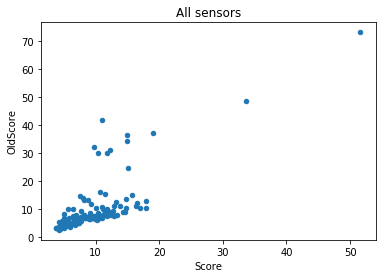

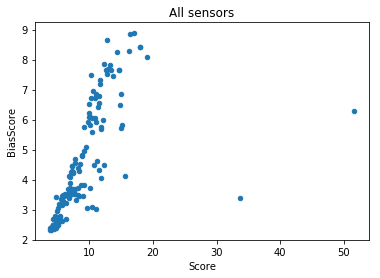

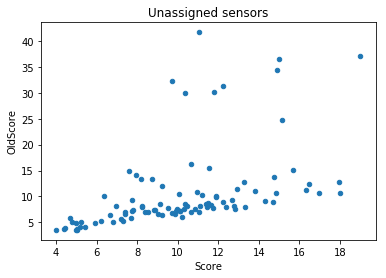

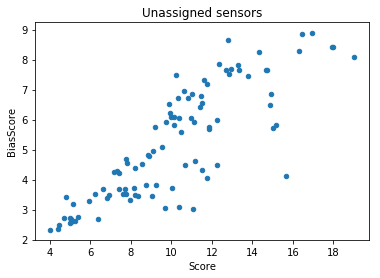

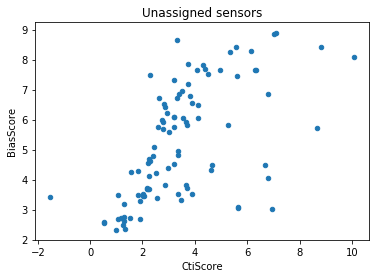

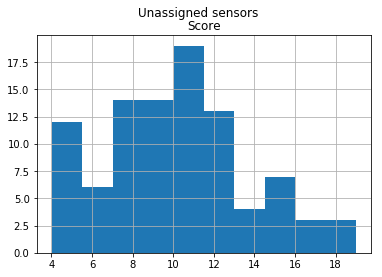

In [9]:
df.plot.scatter(x='Score',y='OldScore',title='All sensors')
df.plot.scatter(x='Score',y='BiasScore', title = 'All sensors')
z=df[(df.Score <= 20 ) & (np.isnan(df.RTM))] # select ones not shown to be on rafts in etraveler
#print (z['RTM'])
z.plot.scatter(x='Score',y='OldScore',title='Unassigned sensors')
z.plot.scatter(x='Score',y='BiasScore', title='Unassigned sensors')
z.plot.scatter(x='CtiScore',y='BiasScore', title='Unassigned sensors' )
z.hist(column='Score')
pl.suptitle("Unassigned sensors")
#plt.scatter(x, y, 80,'b','^',label='', alpha=0.65)
#print (z['Score'])
#print(z)

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
#print(z.sort_values(by='Score'))
z1=z[['Score','BiasScore','CtiScore', 'DefectScore', 'NonlinScore']]
pd.set_option('display.max_rows',200)
print ('number of sensors found in etraveler: ',len(df),'\n')
print ('\n number of unassigned sensors: ',len(z1),'\n')
print ('\n NOTE that some of these have been tentatively assigned to rafts but not yet recorded in eT \n')
round(z1.nsmallest(300,'Score'),2)

number of sensors found in etraveler:  142 


 number of unassigned sensors:  95 


 NOTE that some of these have been tentatively assigned to rafts but not yet recorded in eT 



,Score,BiasScore,CtiScore,DefectScore,NonlinScore
ITL-3800C-076,4.02,2.33,1.00,0.01,0.68
ITL-3800C-419,4.42,2.34,1.35,0.13,0.60
ITL-3800C-040,4.46,2.50,1.25,0.01,0.70
ITL-3800C-340,4.69,2.71,1.18,0.25,0.56
ITL-3800C-142,4.80,3.43,-1.53,1.54,1.36
ITL-3800C-343,4.99,2.71,1.51,0.00,0.77
ITL-3800C-466,5.01,2.55,0.51,1.18,0.77
ITL-3800C-446,5.05,2.59,0.51,1.18,0.77
ITL-3800C-256,5.05,2.69,1.07,0.56,0.74
ITL-3800C-363,5.18,3.18,1.29,0.00,0.70


and we can easily export any of this to an excel file, if you want it.

In [12]:
df.describe()


,OldScore,Score,CtiScore,DefectScore,NonlinScore,BiasScore,RTM
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,45.000000
mean,9.557880,9.114882,3.333915,0.449212,0.815081,4.516674,14.800000
std,9.507806,5.516147,4.485029,1.068372,0.318095,1.894203,5.910699
min,2.681270,3.805314,-1.534706,0.000946,0.143533,2.331974,4.000000
25%,5.046630,5.274412,1.511027,0.004272,0.690030,2.832642,14.000000
50%,7.083303,7.878597,2.408734,0.065308,0.753949,3.819097,17.000000
75%,9.707337,11.167542,3.681789,0.249565,0.883364,6.032662,18.000000
max,73.170525,51.610014,43.883984,8.722778,1.957874,8.900260,21.000000


In [13]:
z1.describe()

,Score,BiasScore,CtiScore,DefectScore,NonlinScore
count,95.000000,95.000000,95.000000,95.000000,95.000000
mean,10.144194,5.215372,3.462868,0.627060,0.838894
std,3.452902,1.891506,1.967352,1.268596,0.339973
min,4.015016,2.331974,-1.534706,0.000946,0.143533
25%,7.731477,3.529451,2.222765,0.004715,0.695928
50%,10.135477,4.831569,3.215609,0.065613,0.754496
75%,12.055166,6.755014,4.222465,0.493118,0.899102
max,19.015588,8.900260,10.080841,8.722778,1.957874


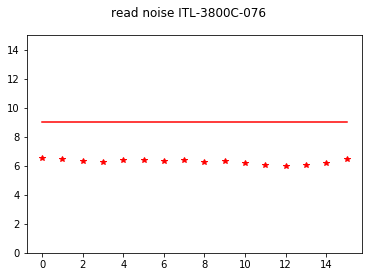

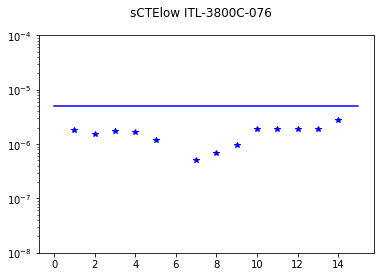

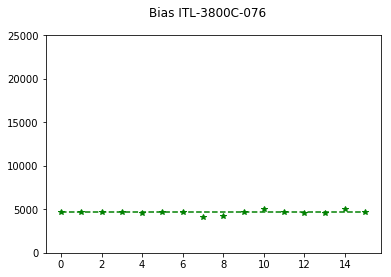

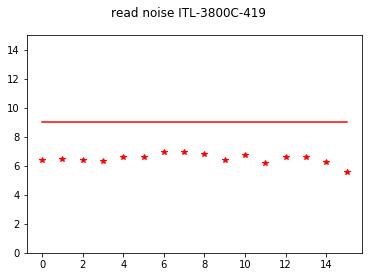

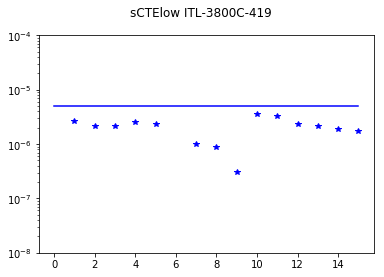

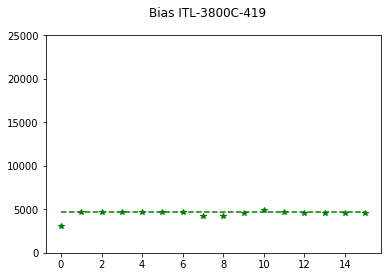

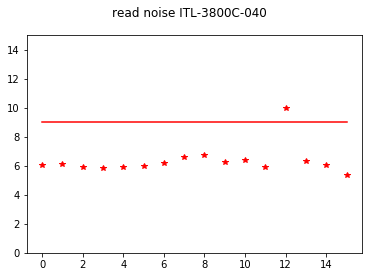

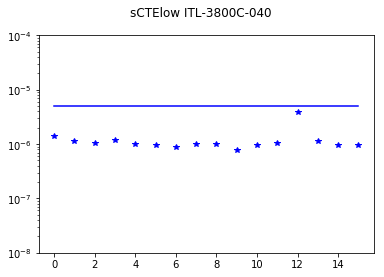

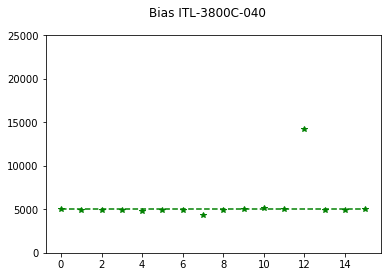

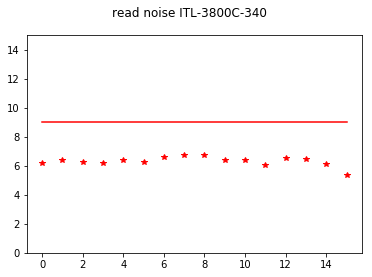

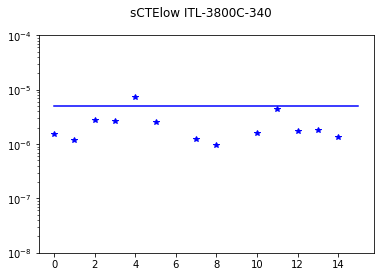

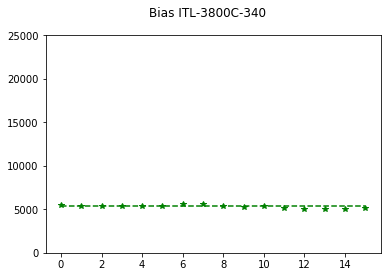

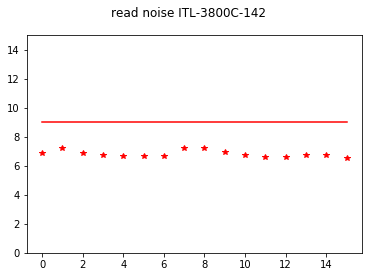

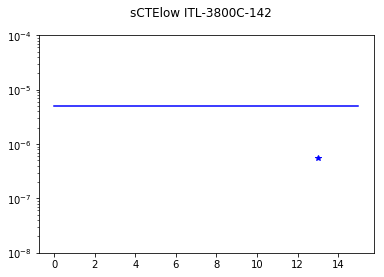

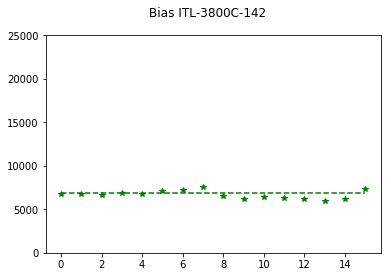

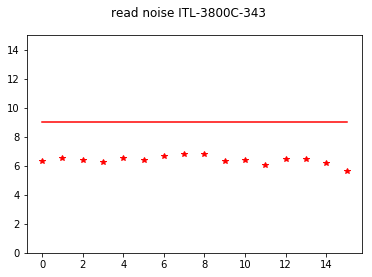

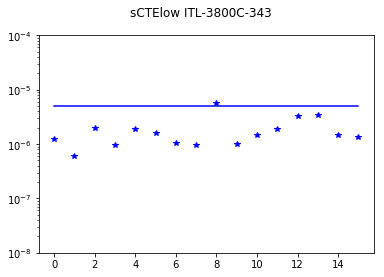

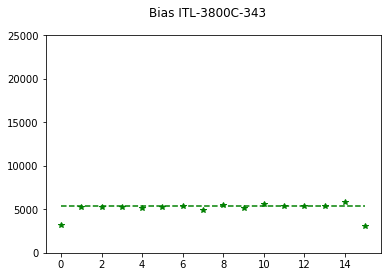

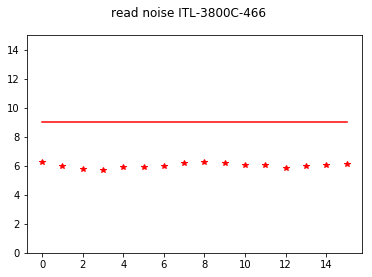

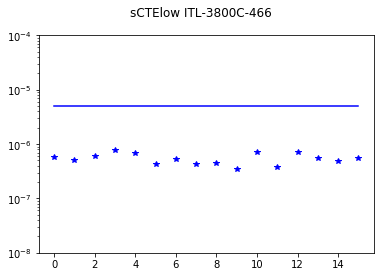

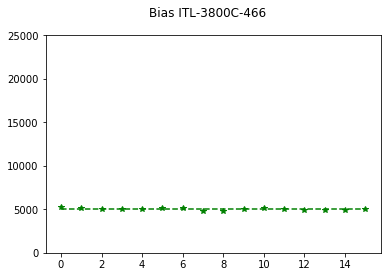

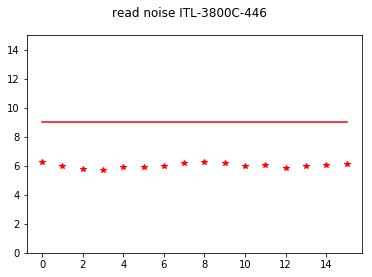

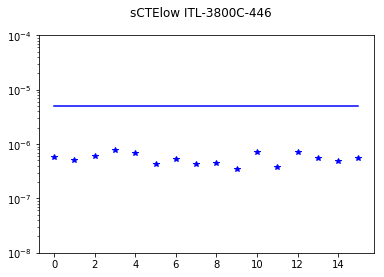

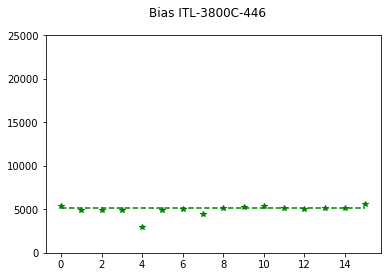

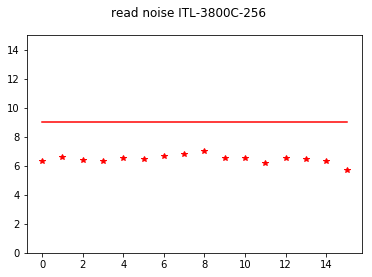

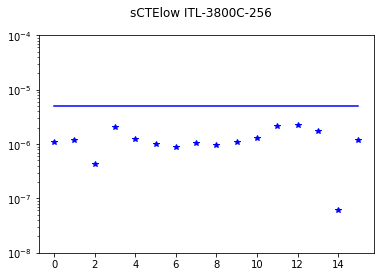

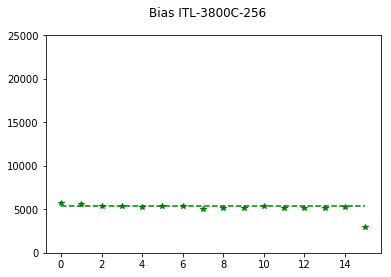

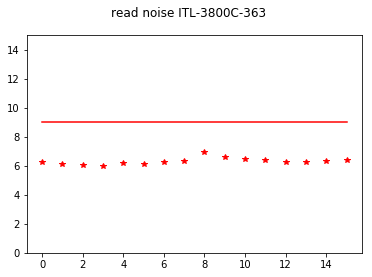

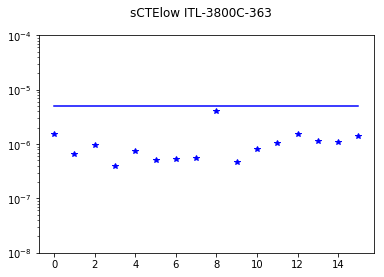

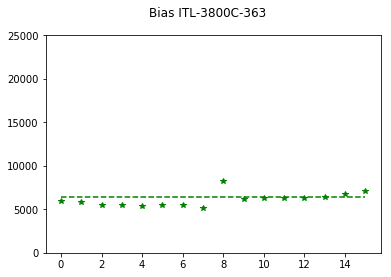

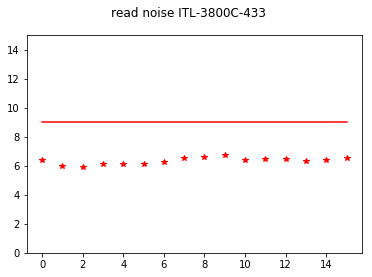

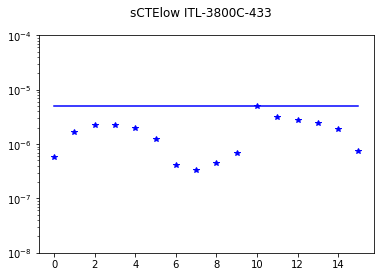

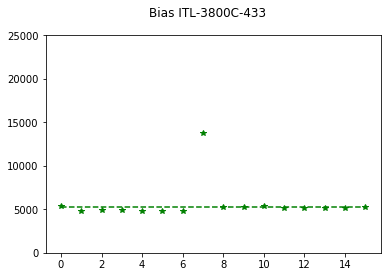

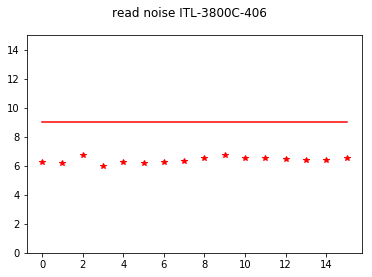

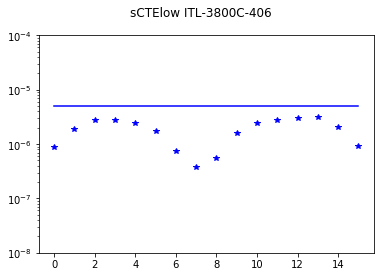

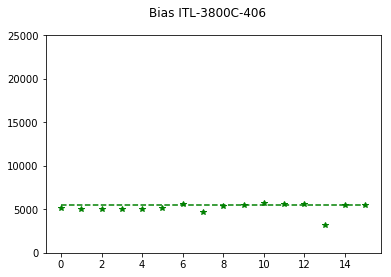

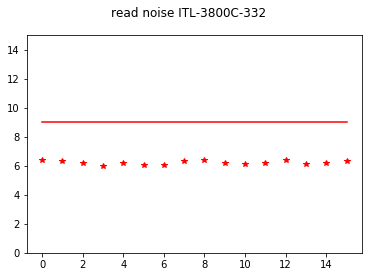

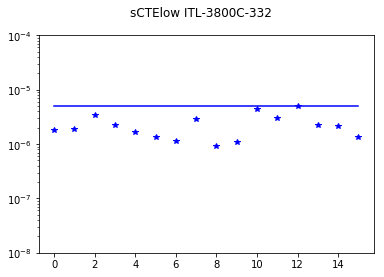

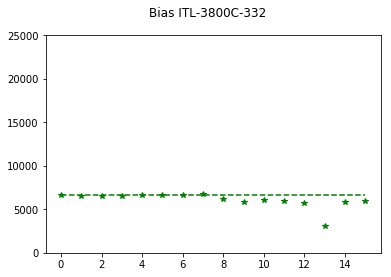

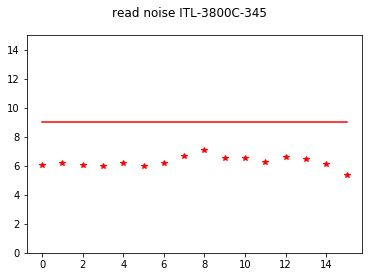

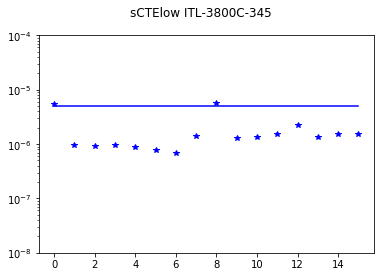

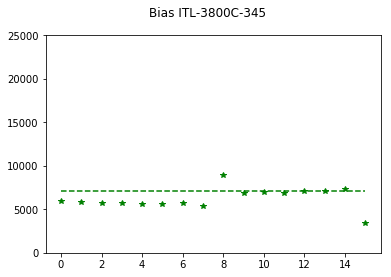

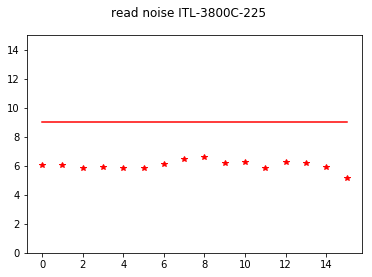

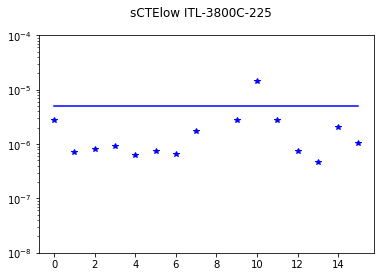

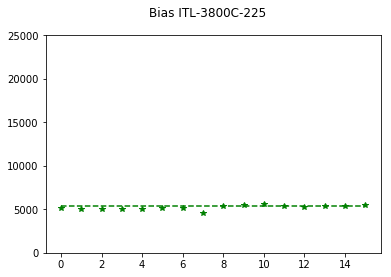

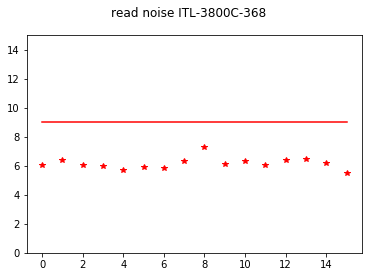

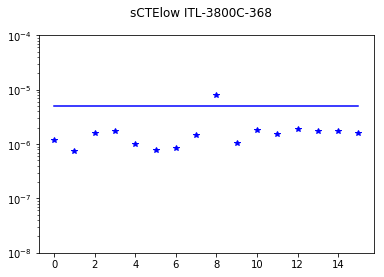

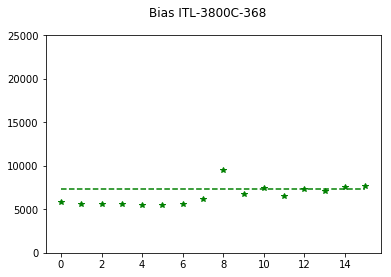

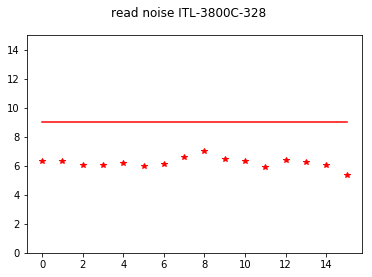

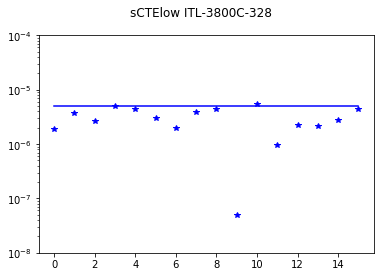

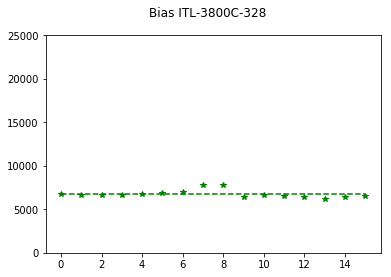

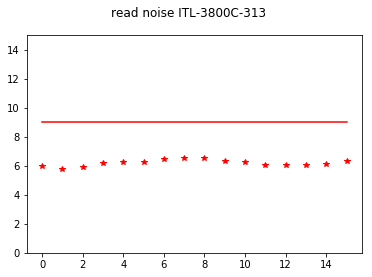

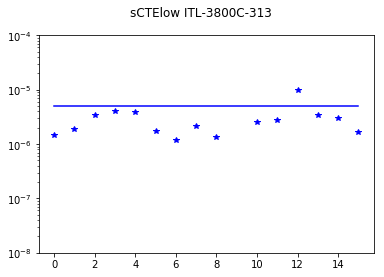

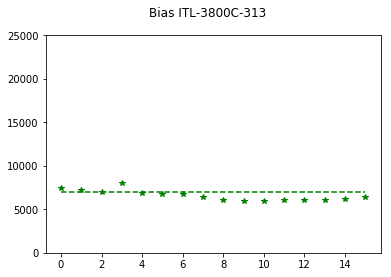

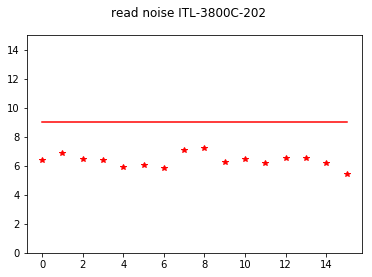

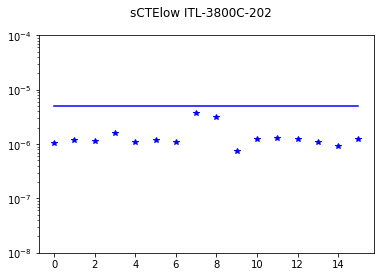

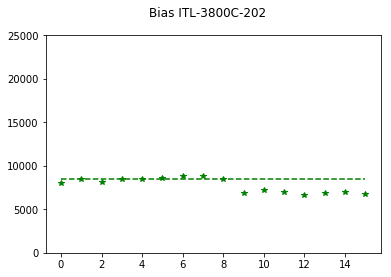

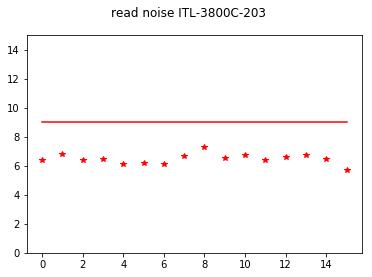

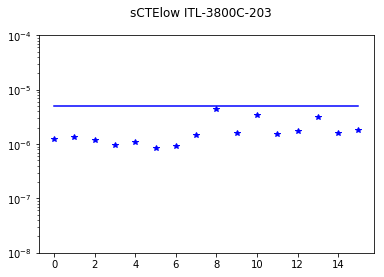

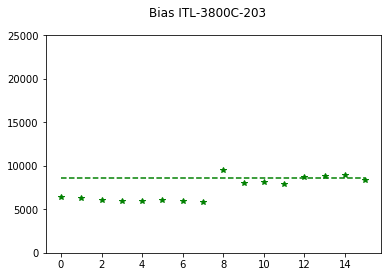

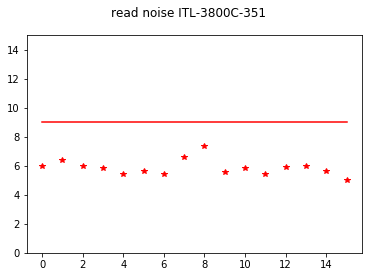

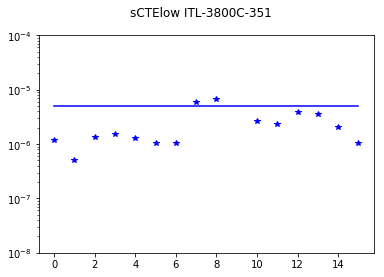

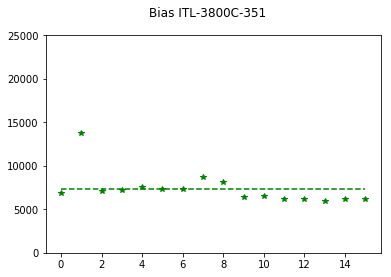

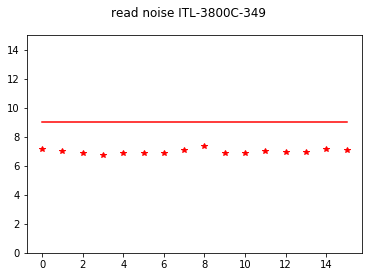

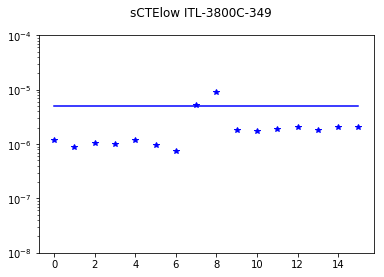

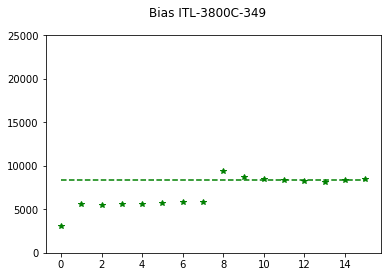

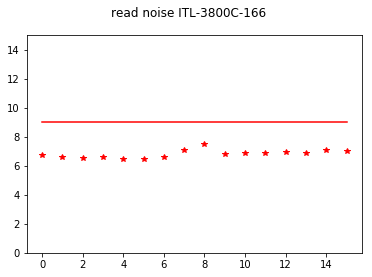

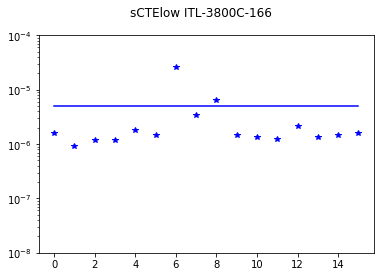

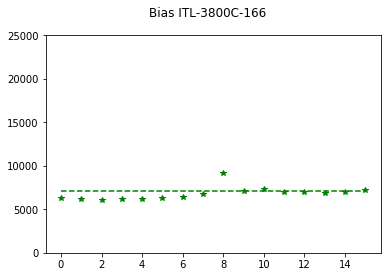

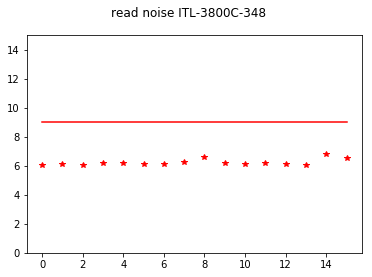

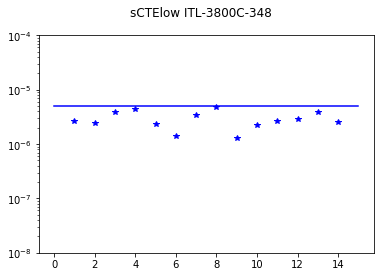

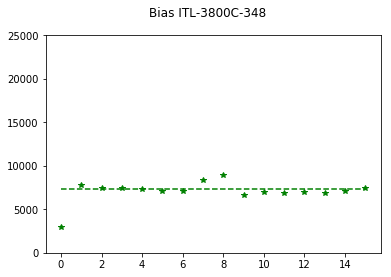

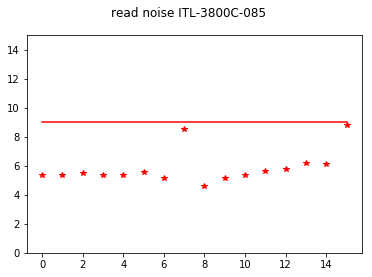

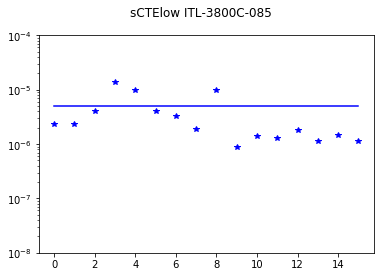

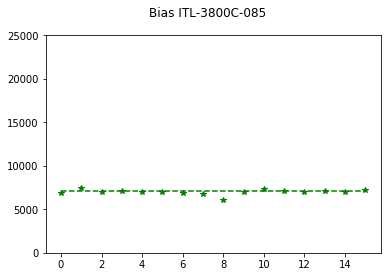

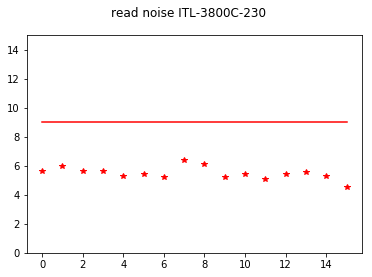

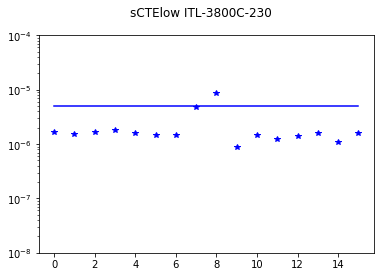

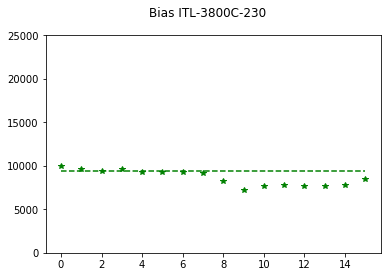

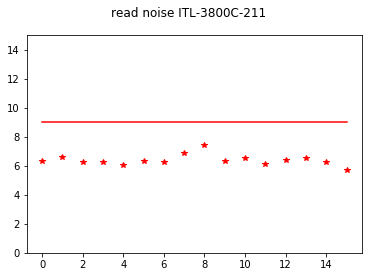

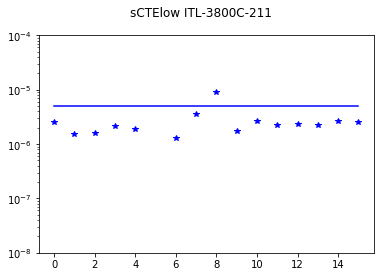

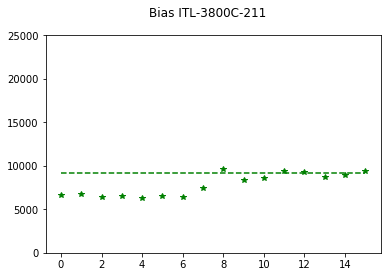

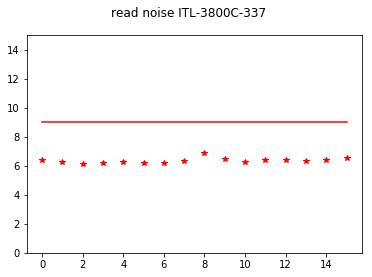

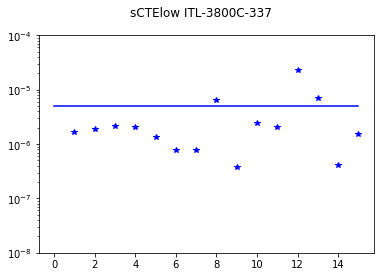

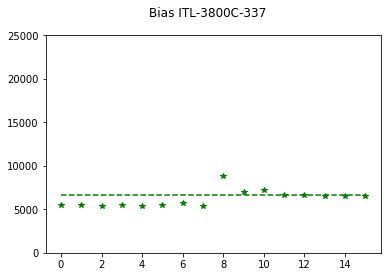

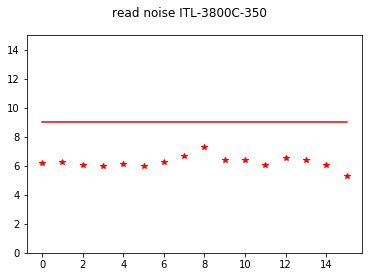

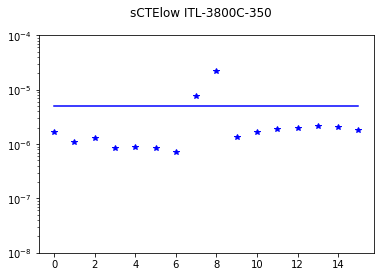

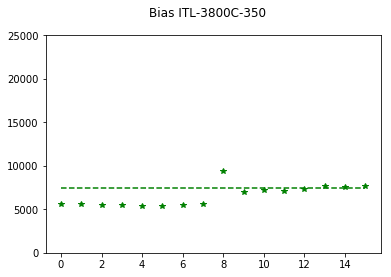

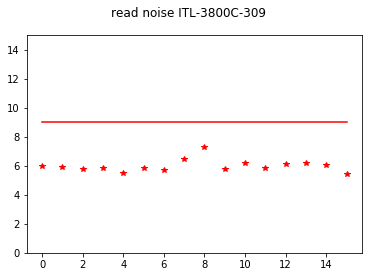

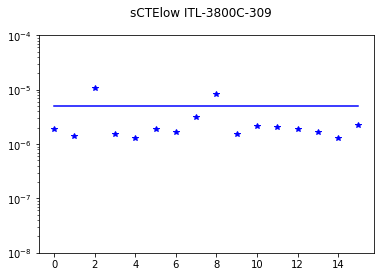

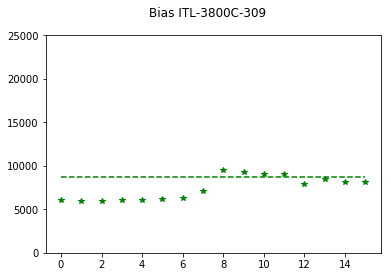

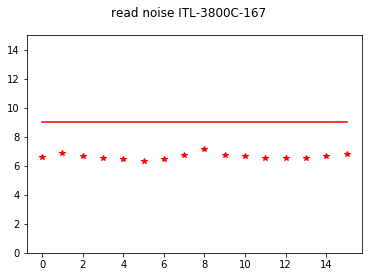

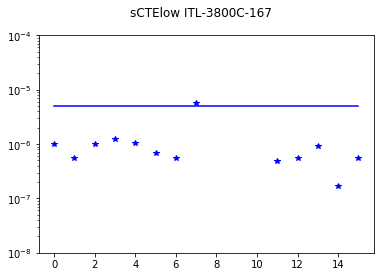

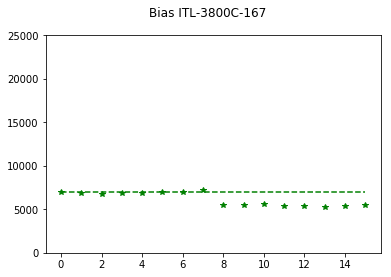

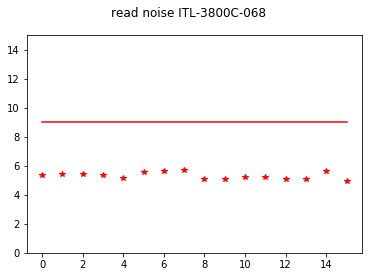

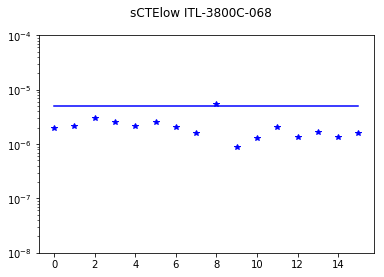

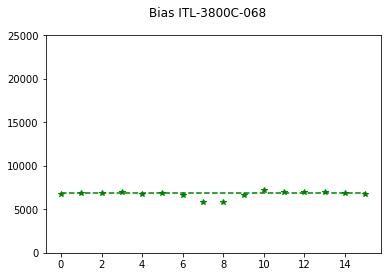

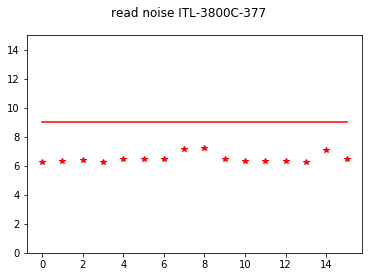

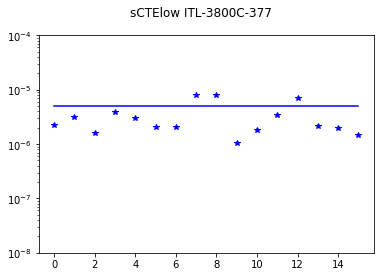

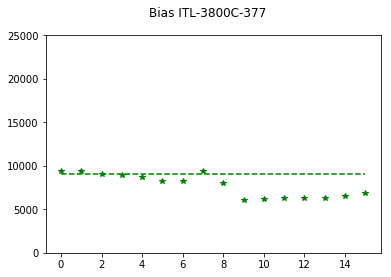

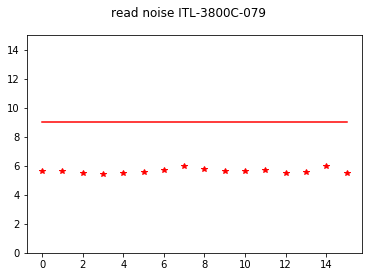

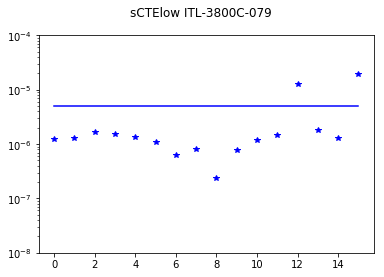

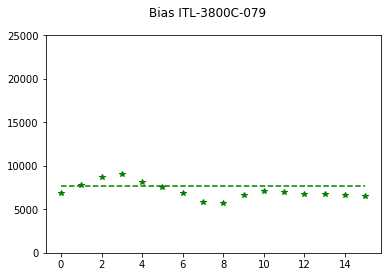

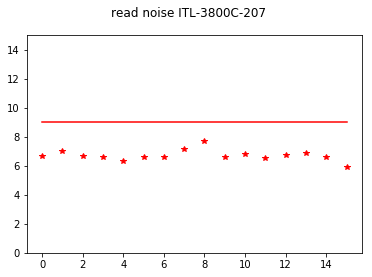

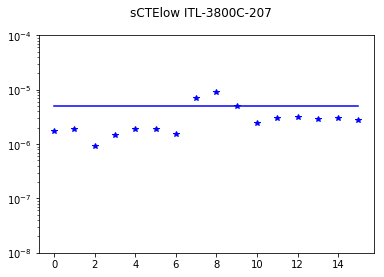

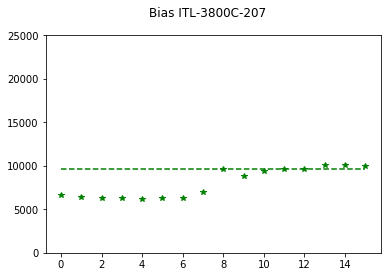

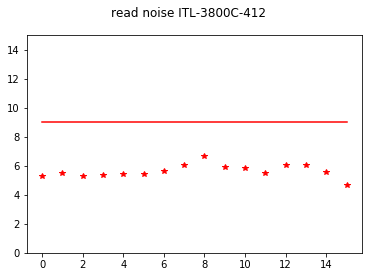

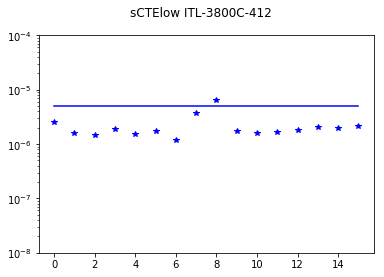

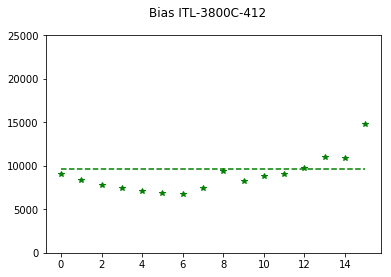

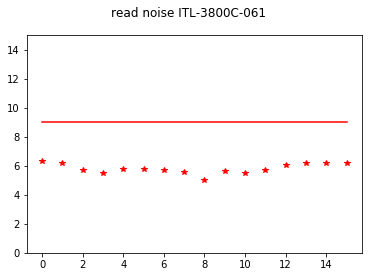

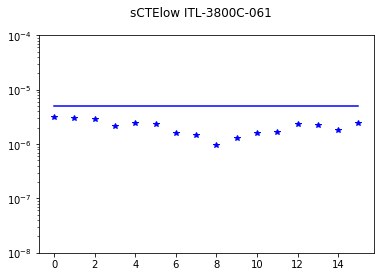

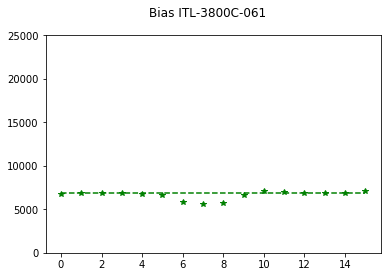

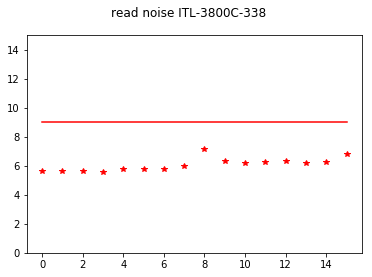

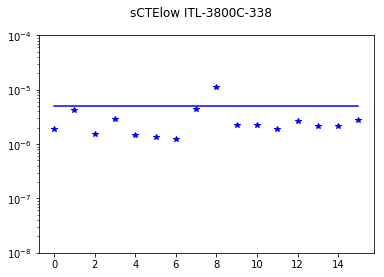

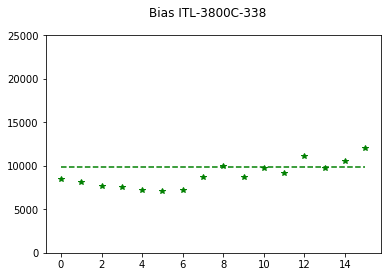

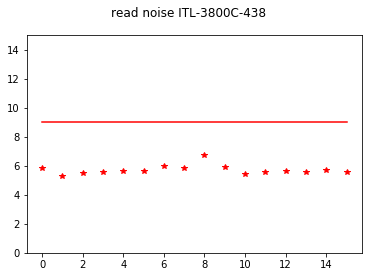

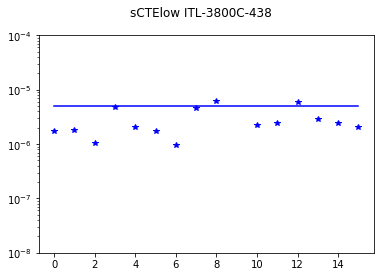

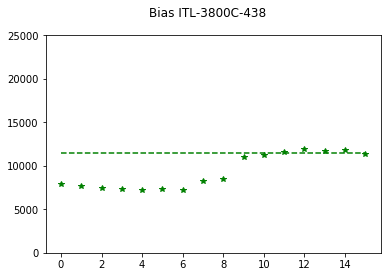

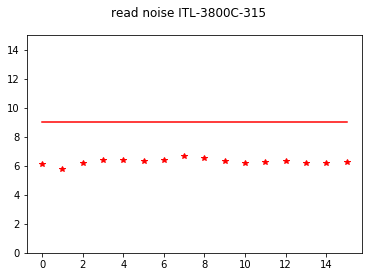

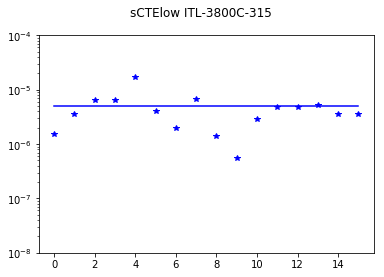

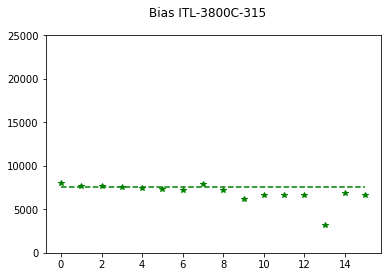

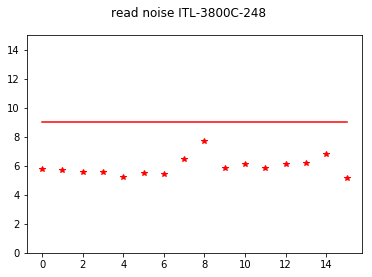

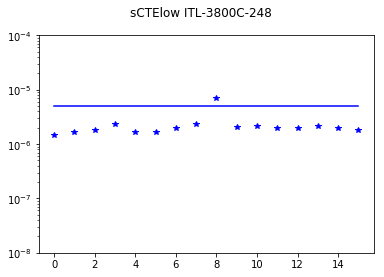

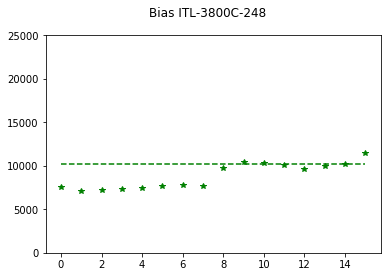

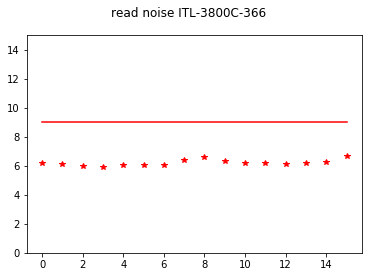

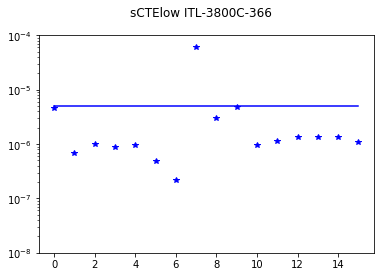

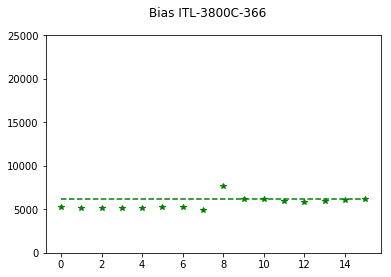

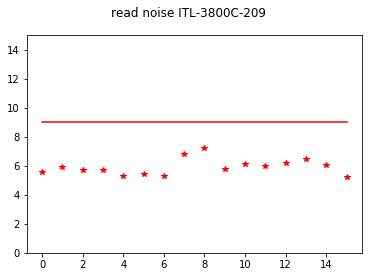

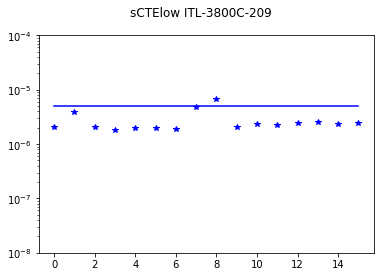

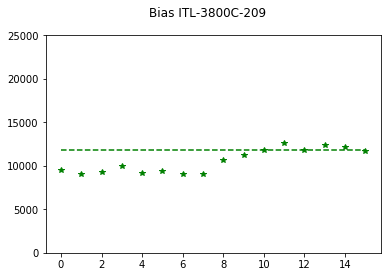

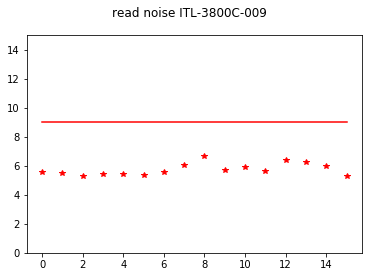

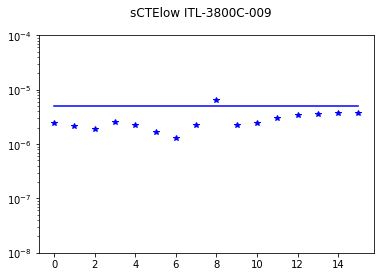

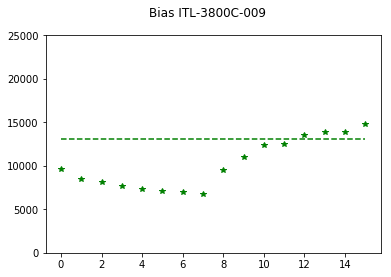

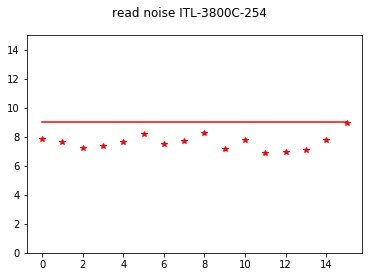

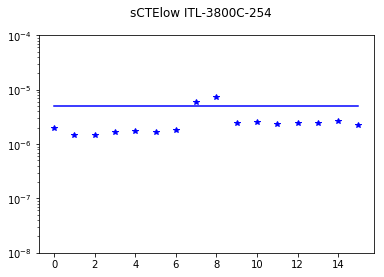

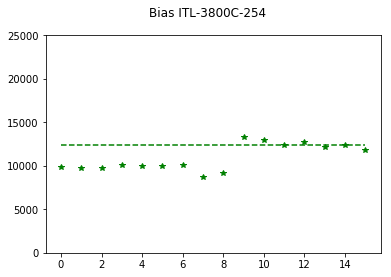

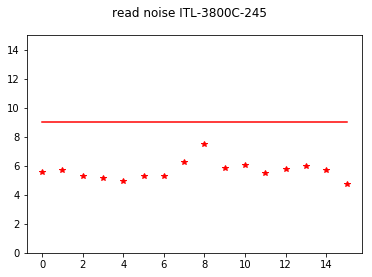

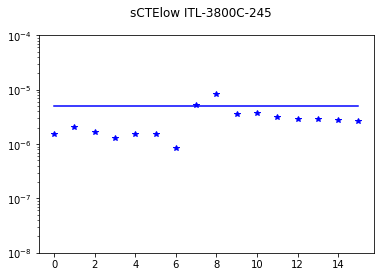

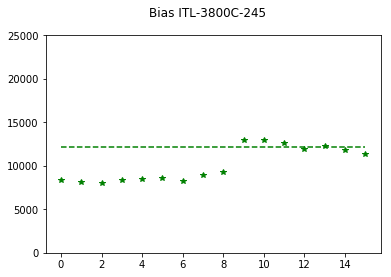

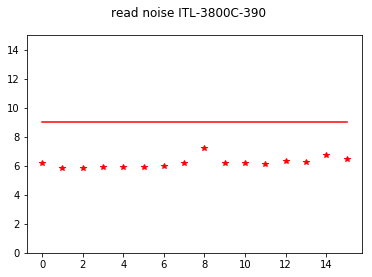

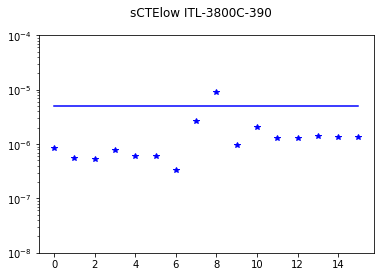

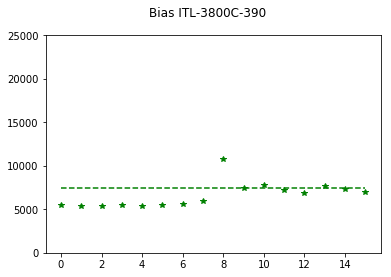

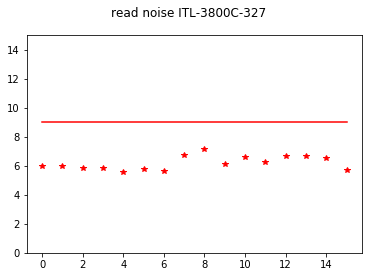

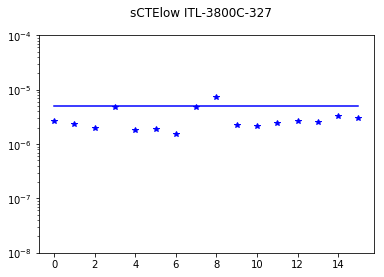

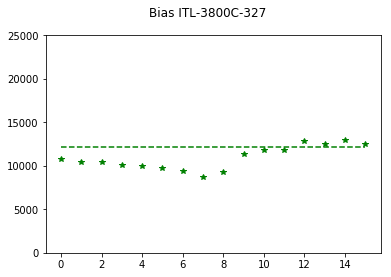

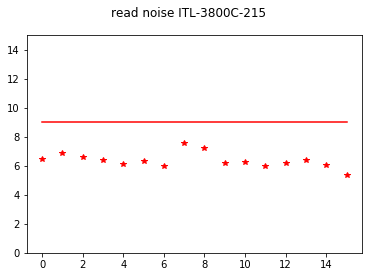

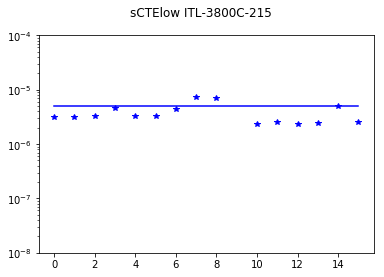

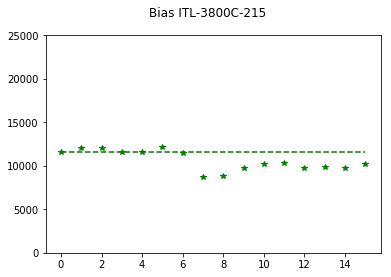

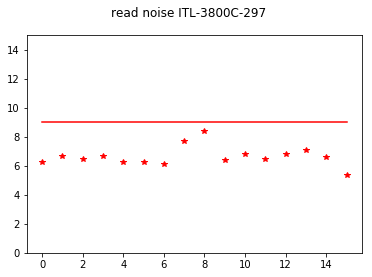

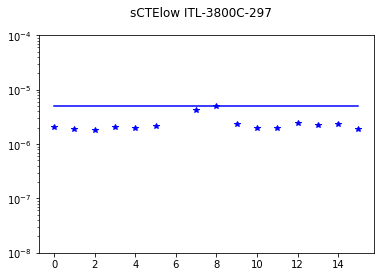

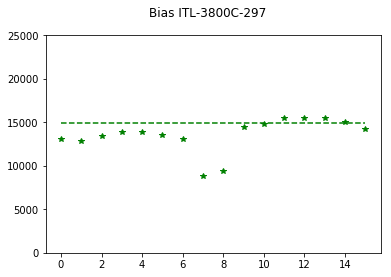

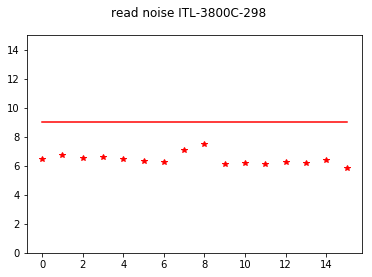

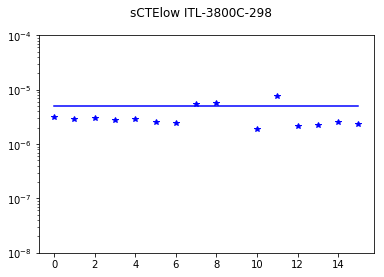

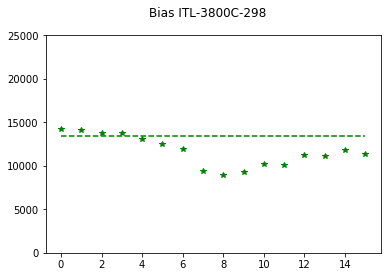

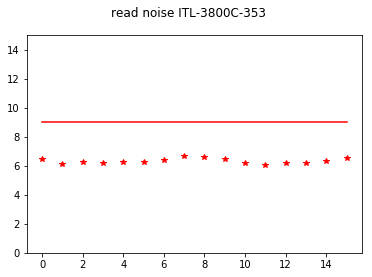

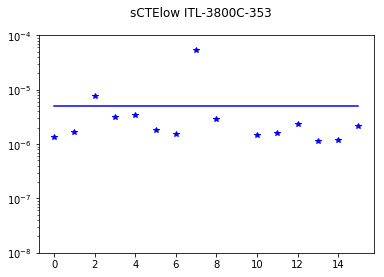

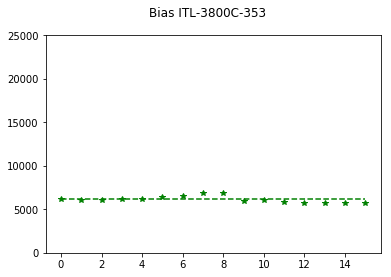

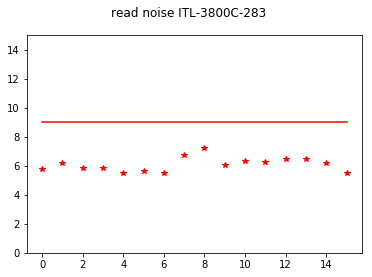

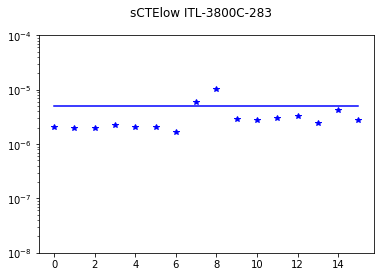

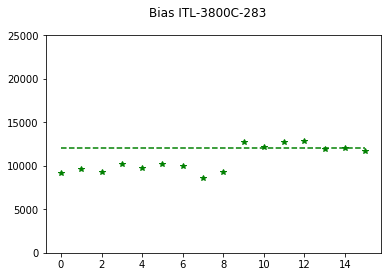

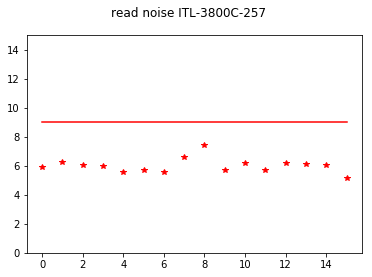

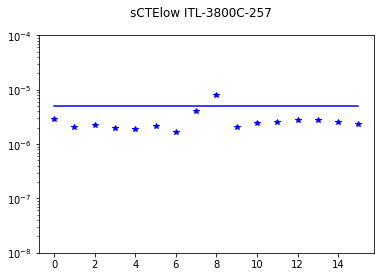

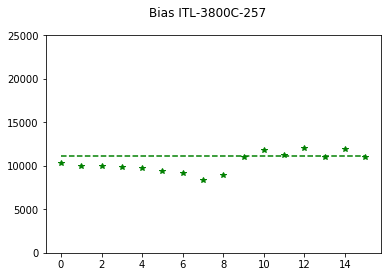

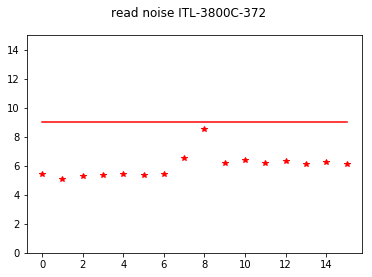

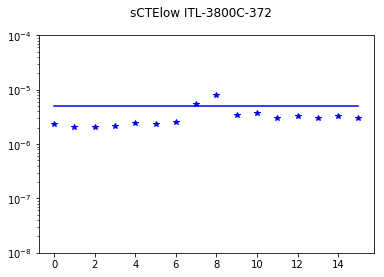

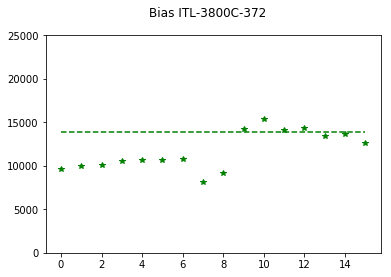

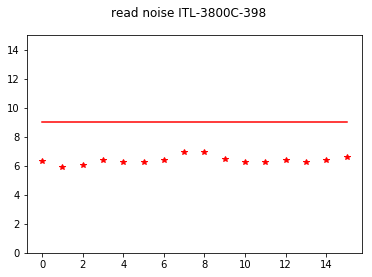

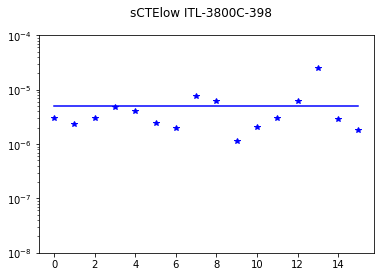

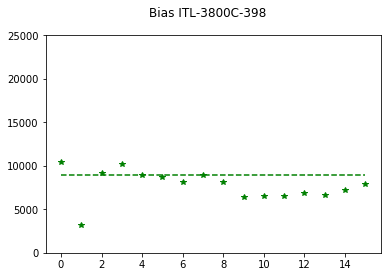

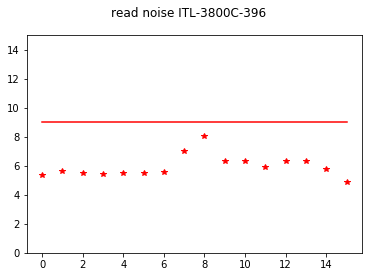

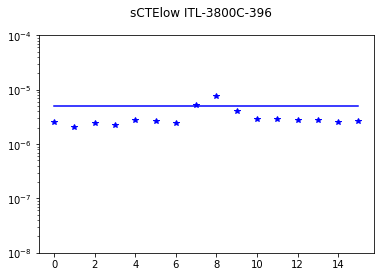

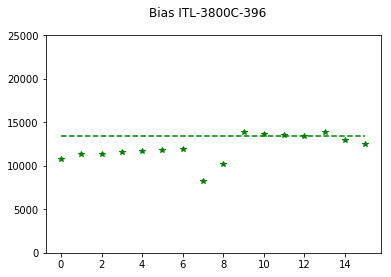

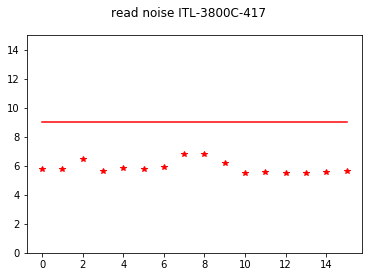

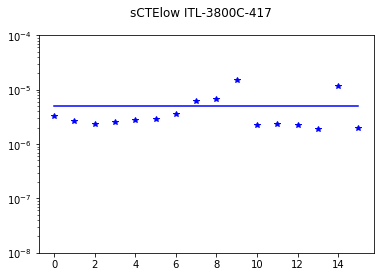

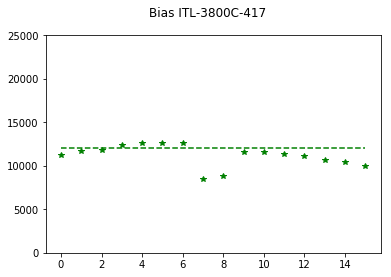

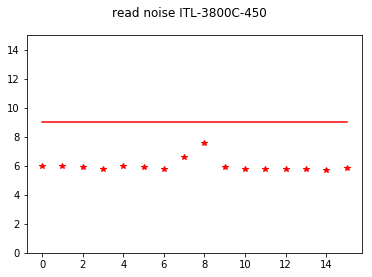

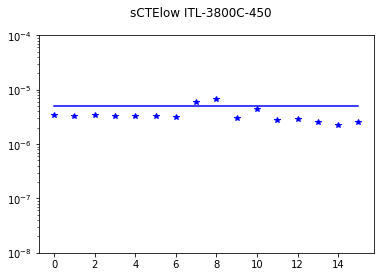

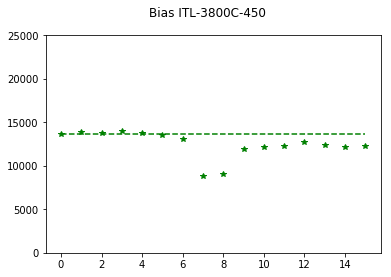

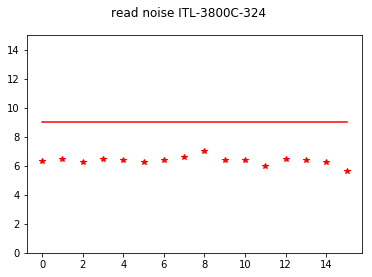

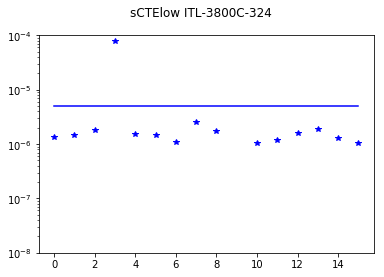

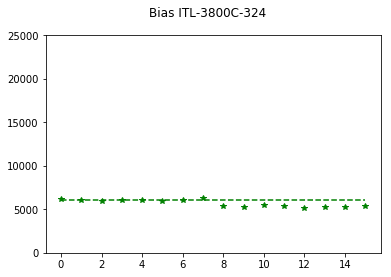

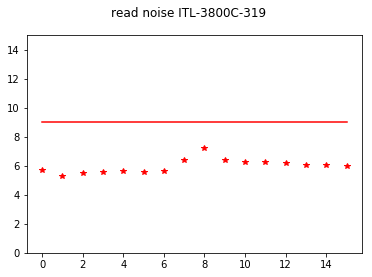

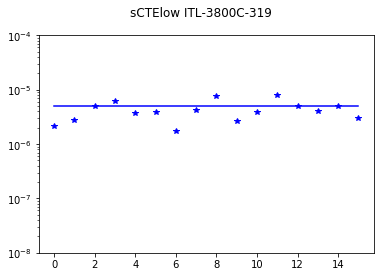

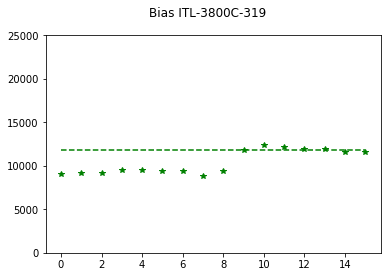

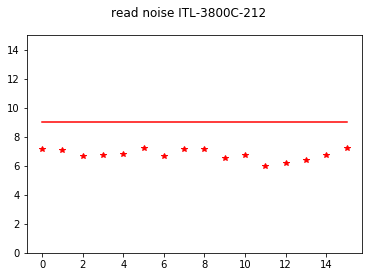

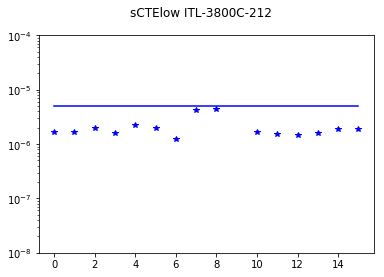

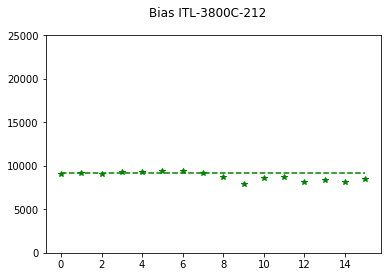

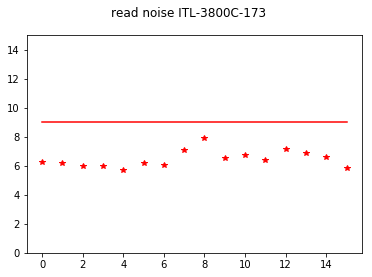

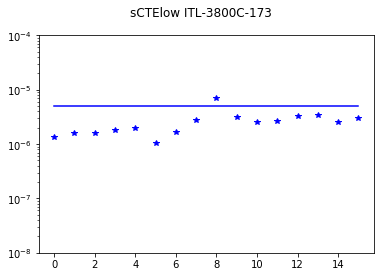

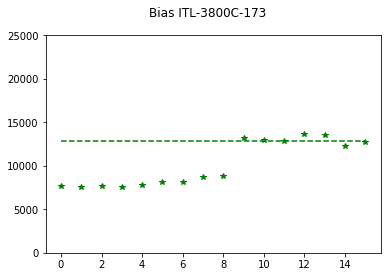

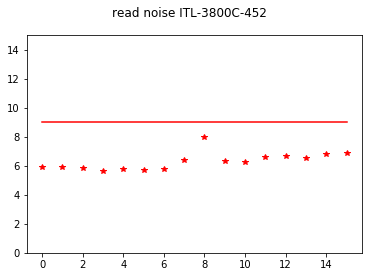

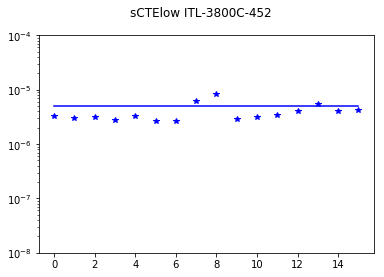

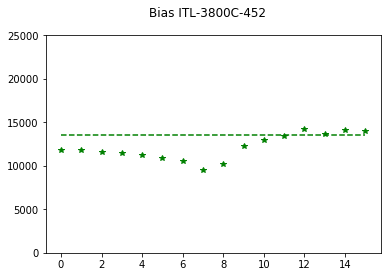

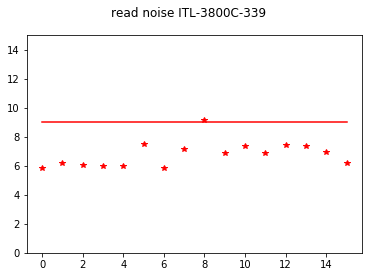

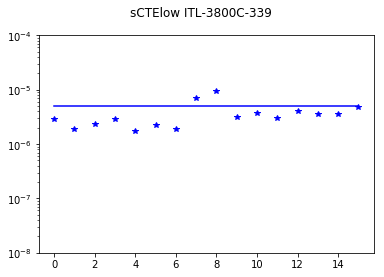

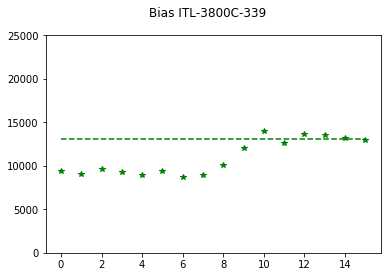

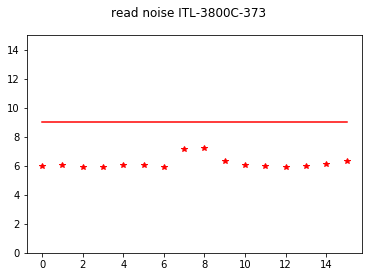

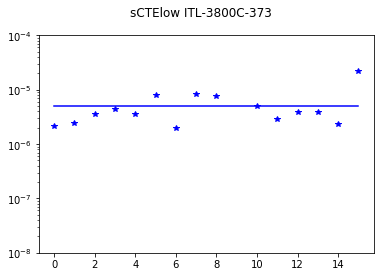

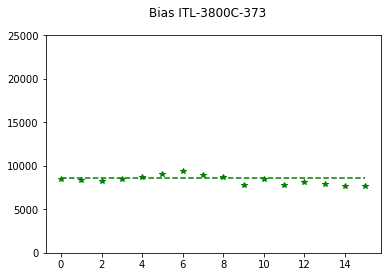

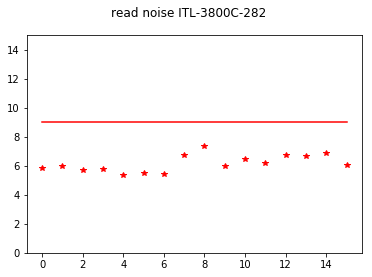

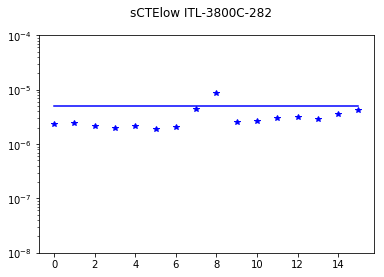

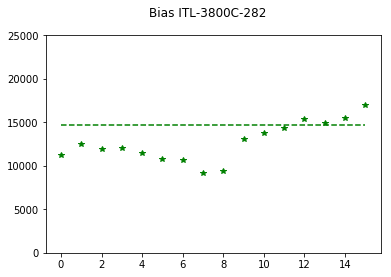

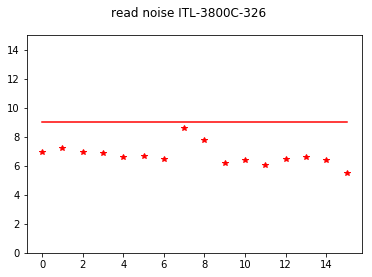

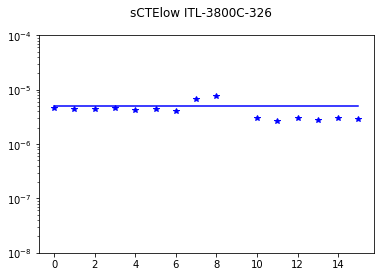

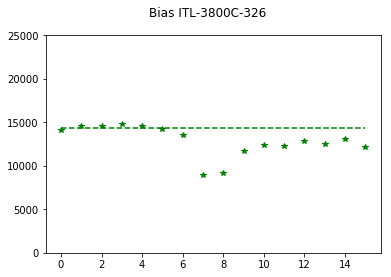

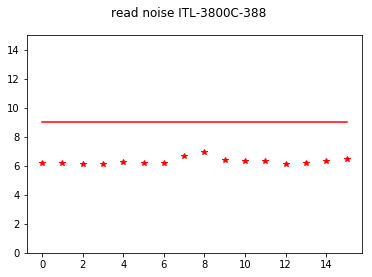

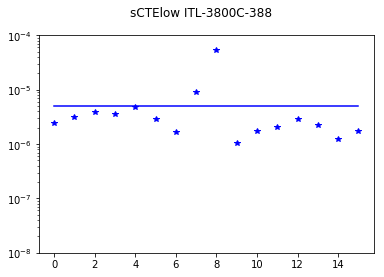

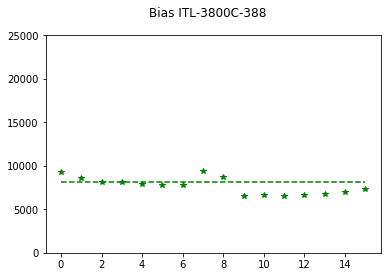

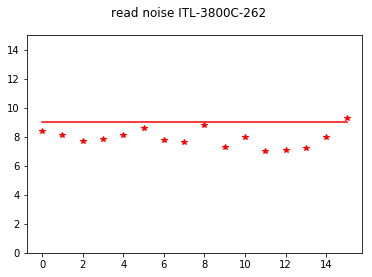

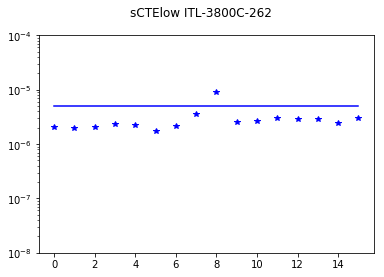

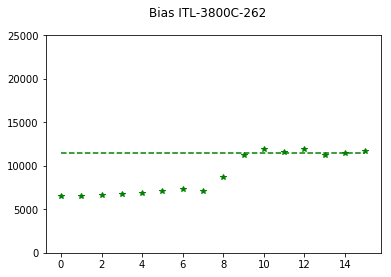

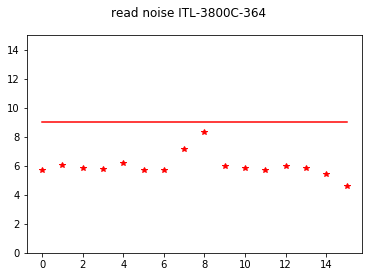

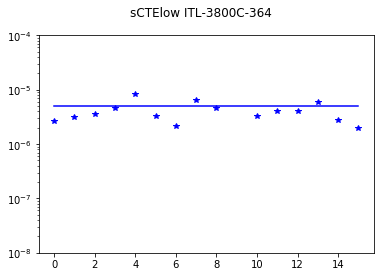

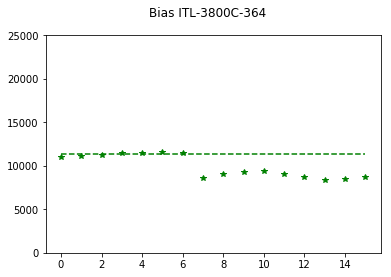

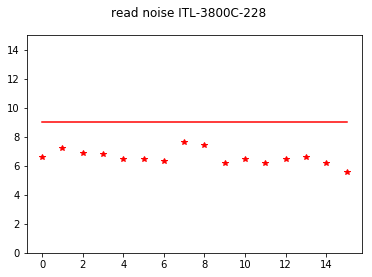

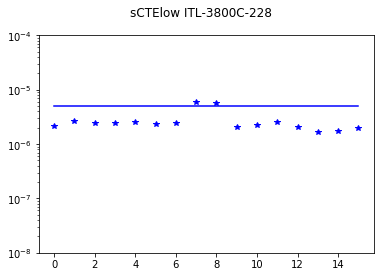

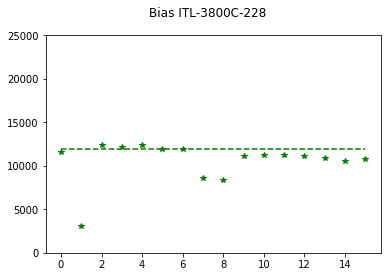

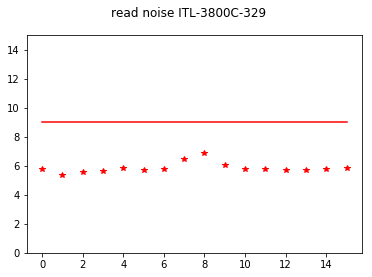

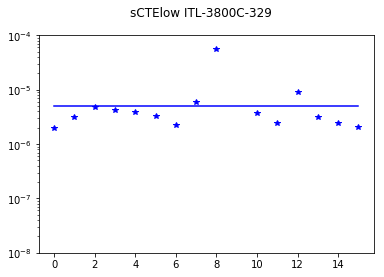

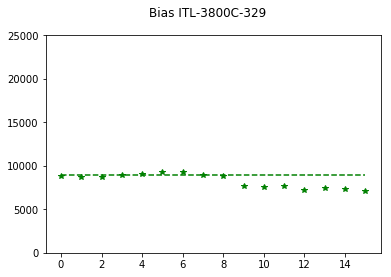

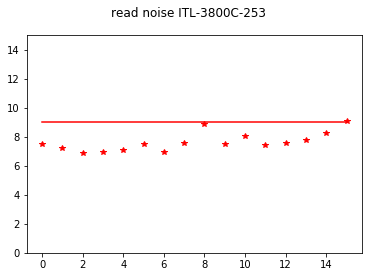

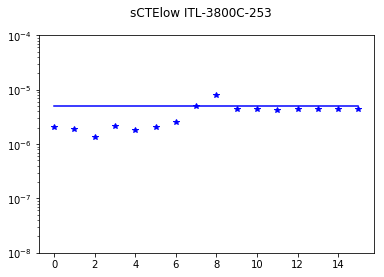

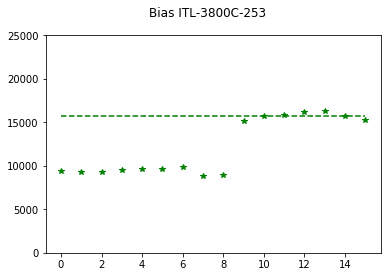

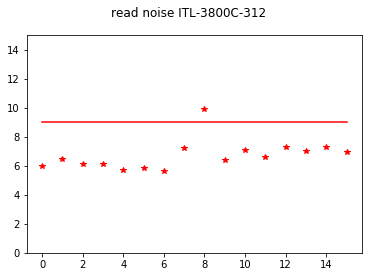

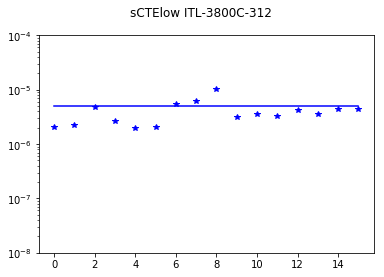

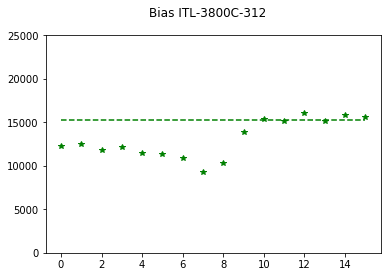

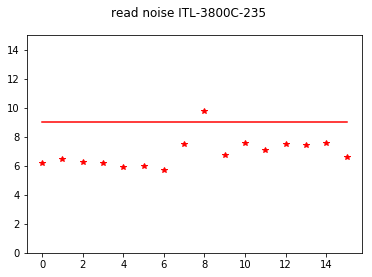

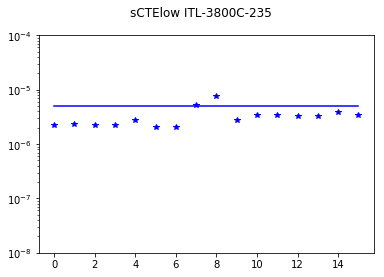

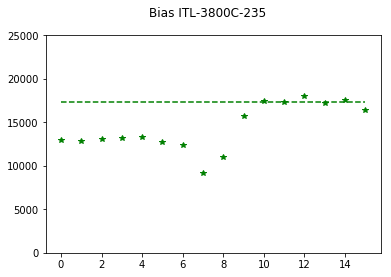

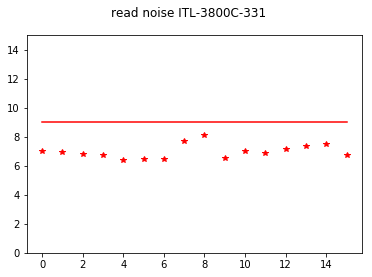

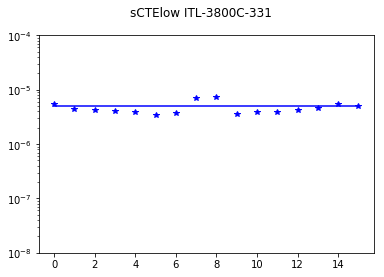

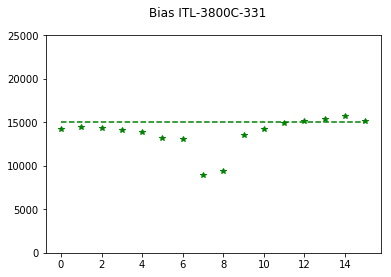

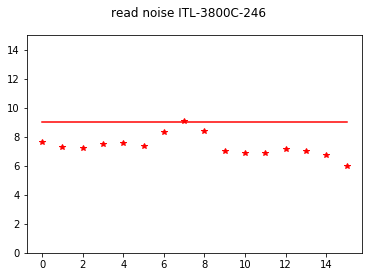

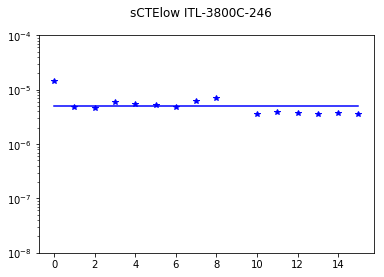

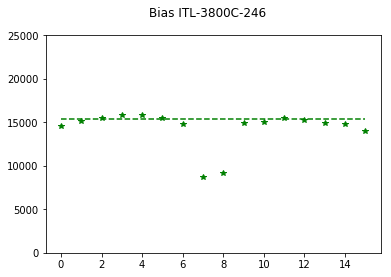

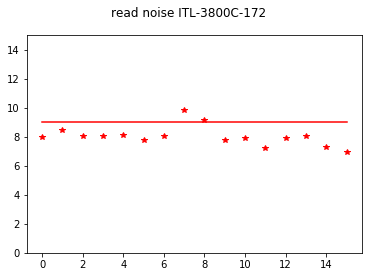

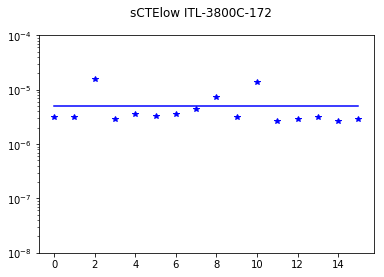

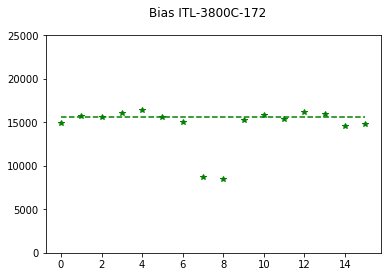

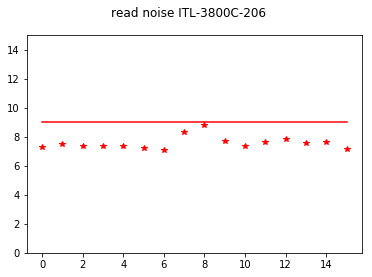

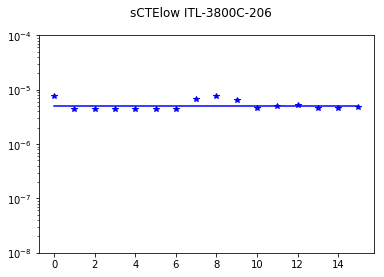

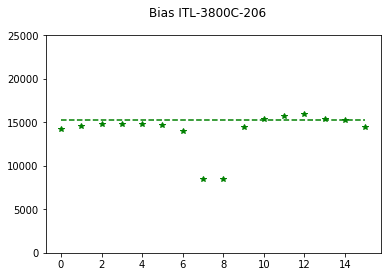

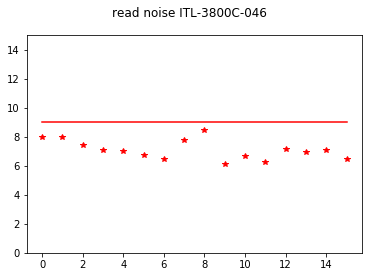

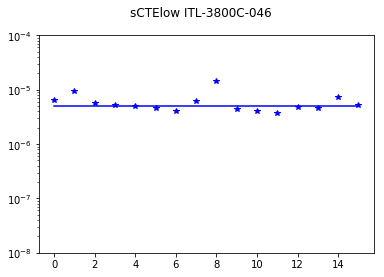

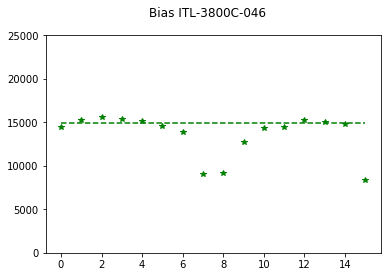

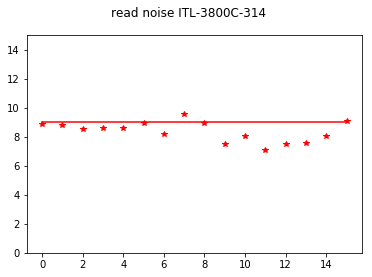

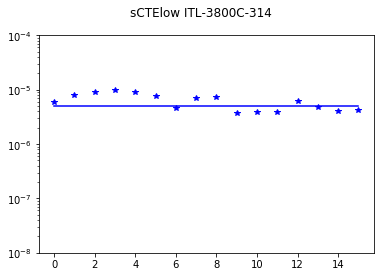

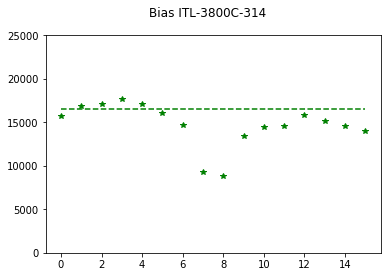

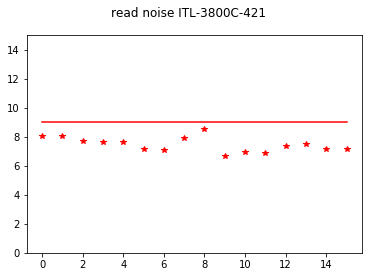

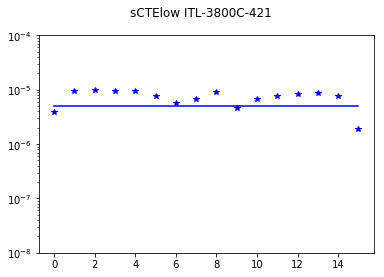

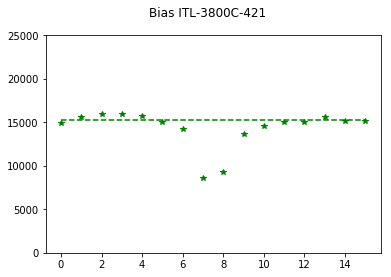

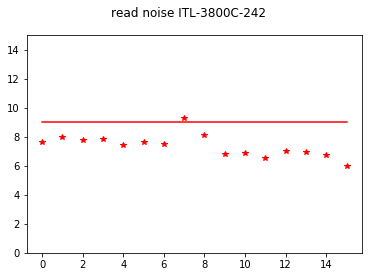

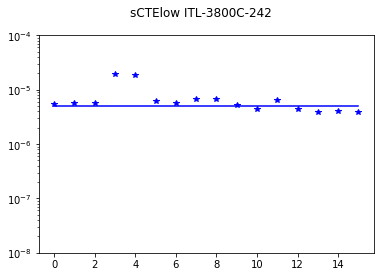

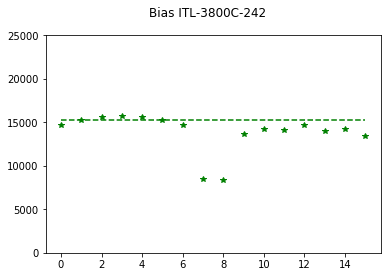

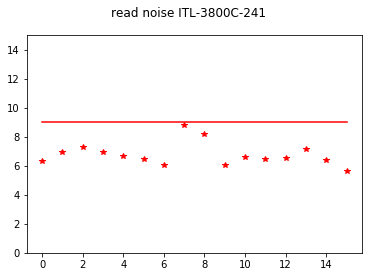

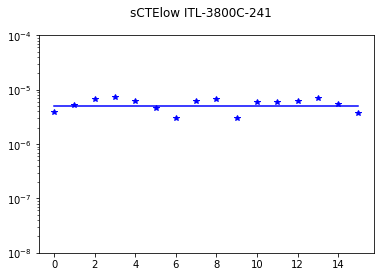

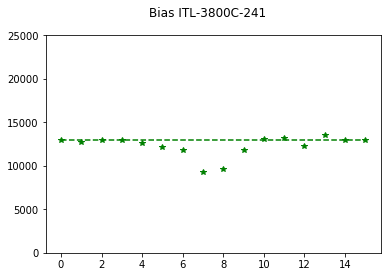

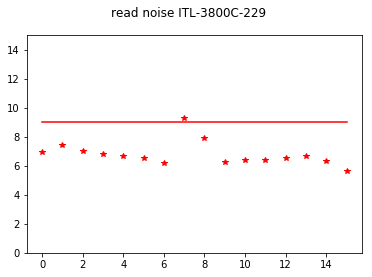

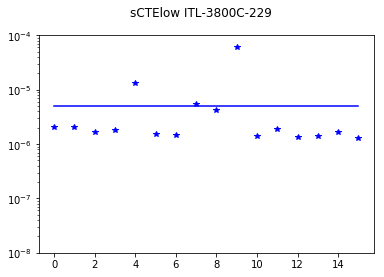

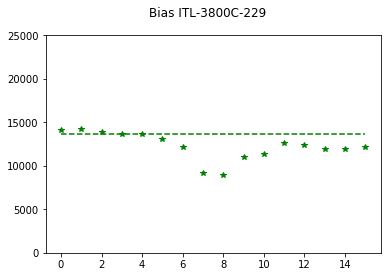

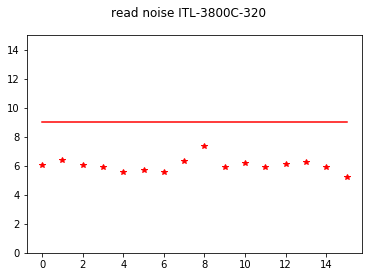

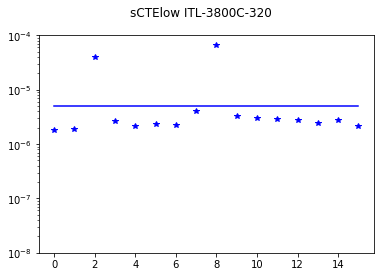

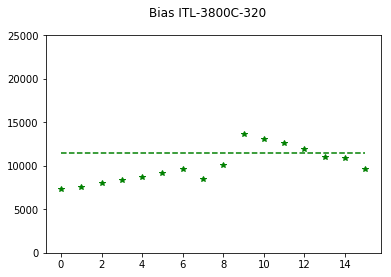

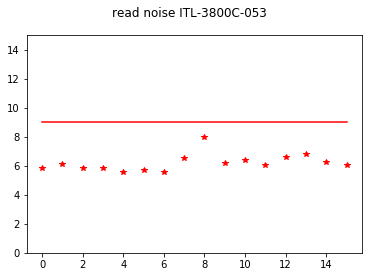

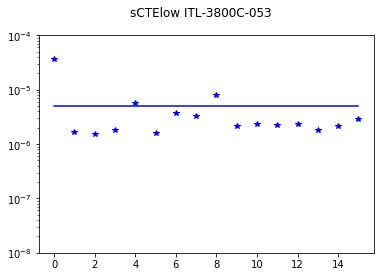

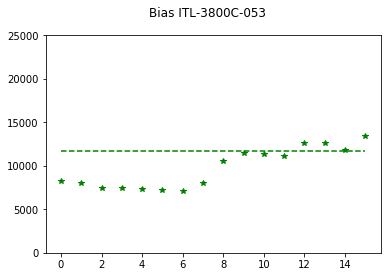

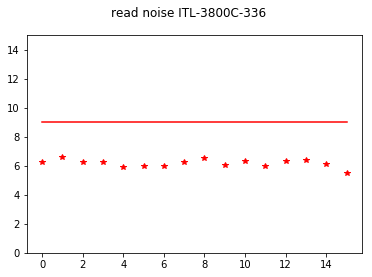

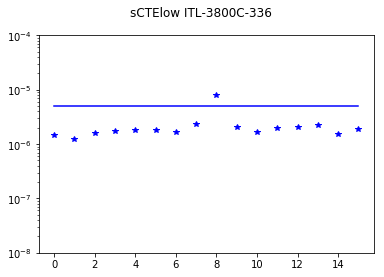

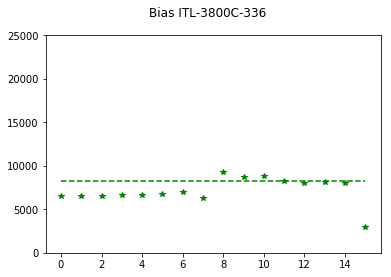

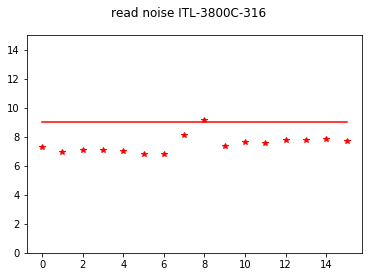

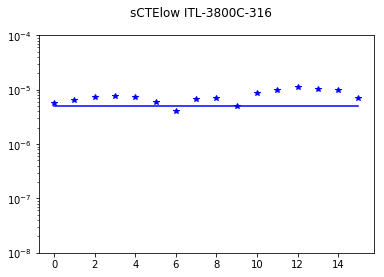

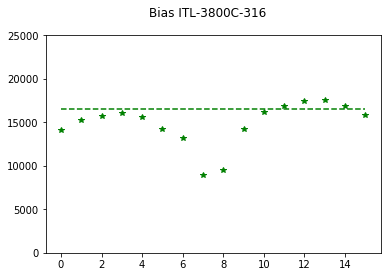

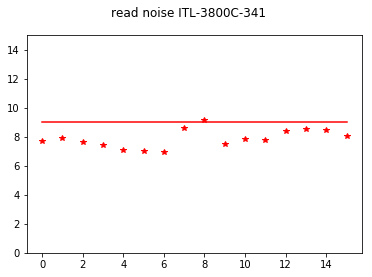

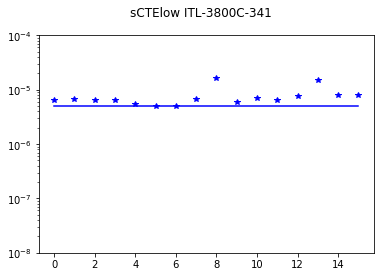

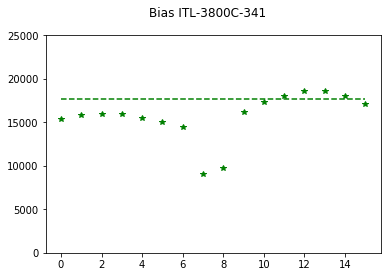

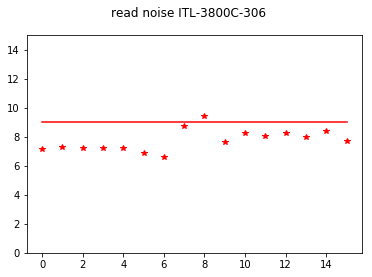

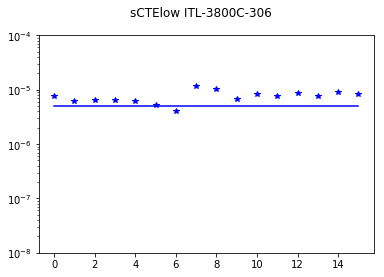

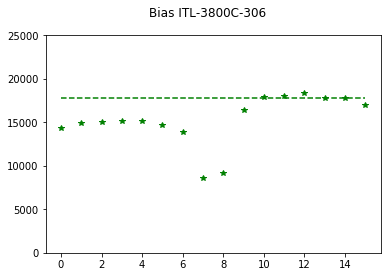

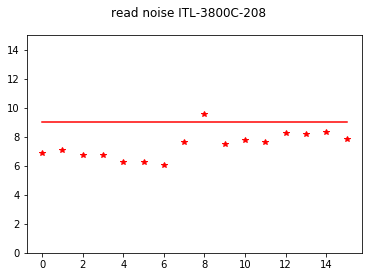

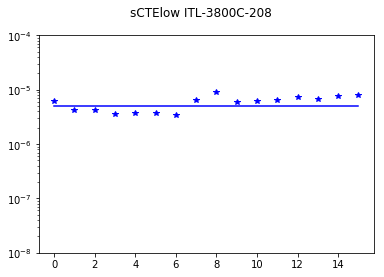

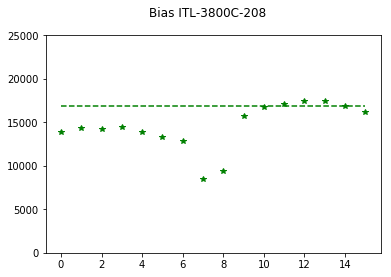

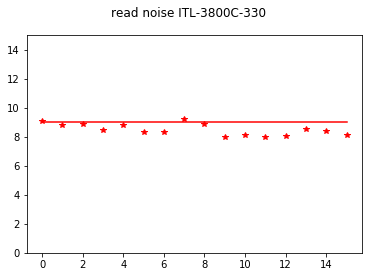

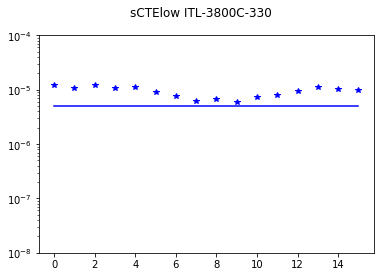

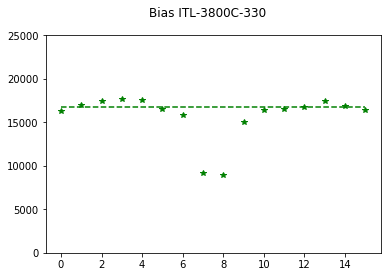

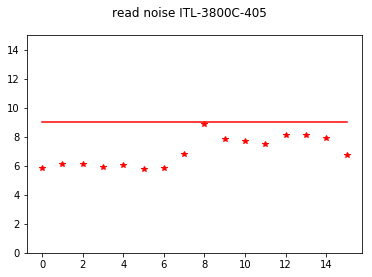

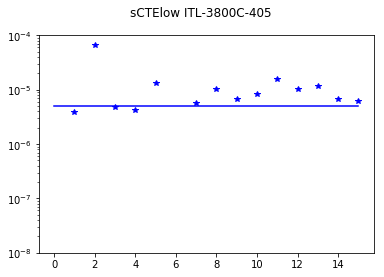

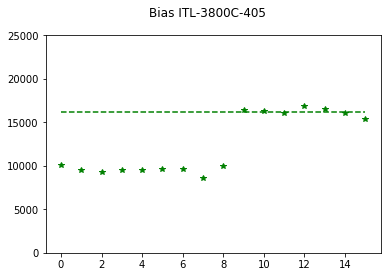

In [14]:
    # let's have a look at some things, ordered by the metric

    z2=z1.nsmallest(300,'Score')
    # (pardon the simplistic way this correlation plot is done, a matplot slowness workaround)
    ampcitls=[]
    ampbias=[]
    iamp=0
    for ccd in z2.index:
        defectsfrac, nbcs = defectsFraction(expDict,ccd)
        nbc=nbcs.sum()

        ctils, ctihs, ctilp, ctihp = get_CTI(expDict,ccd,0)
        ctemax=max(ctils.max(),ctihs.max())
        rn = get_readnoise(expDict,ccd)

        bias = bias_dic[ccd]
        biases = biases_dic[ccd]
        RTM = RTM_dic[ccd]
        nonlinearity = get_nonlinearity(expDict, ccd)


        plt.figure()
        plt.plot(rn, 'r*')
        plt.ylim(0,15)
        lab='read noise '+ccd
        plt.suptitle(lab)
        lim9=rn*0.+9.
        plt.plot(lim9, '-r')
        # now let's look at CTI distributions
        plt.figure()
        plt.plot(ctils, 'b*')
        plt.ylim(1.e-8,100e-6)
        lab='sCTElow '+ccd
        plt.suptitle(lab)
        plt.yscale("log")
        lim9=rn*0.+5.e-6
        plt.plot(lim9, '-b')
        # now let's look at bias distributions
        plt.figure()
        plt.plot(biases, 'g*')
        plt.ylim(0.,25000.)
        lab='Bias '+ccd
        plt.suptitle(lab)
        #plt.yscale("log")
        lim9=rn*0.+bias
        plt.plot(lim9, '--g')
        
        for i in range(0,len(ctils)):
            ampcitls.append(ctils[i])
            ampbias.append(biases[i])
#    fig1=plt.figure(1,[figwidth,figheight])
#    plt.plot(ampbias,ampcitls,'*')
#    plt.yscale("log")
#    slim=0.*np.array(ampcitls)+5.e-6
#    plt.plot(ampbias,slim, '-b')
#    lab='sCTI vs bias all amps'
#    plt.suptitle(lab)



Text(0.5,0.98,'sCTI vs bias all amps')

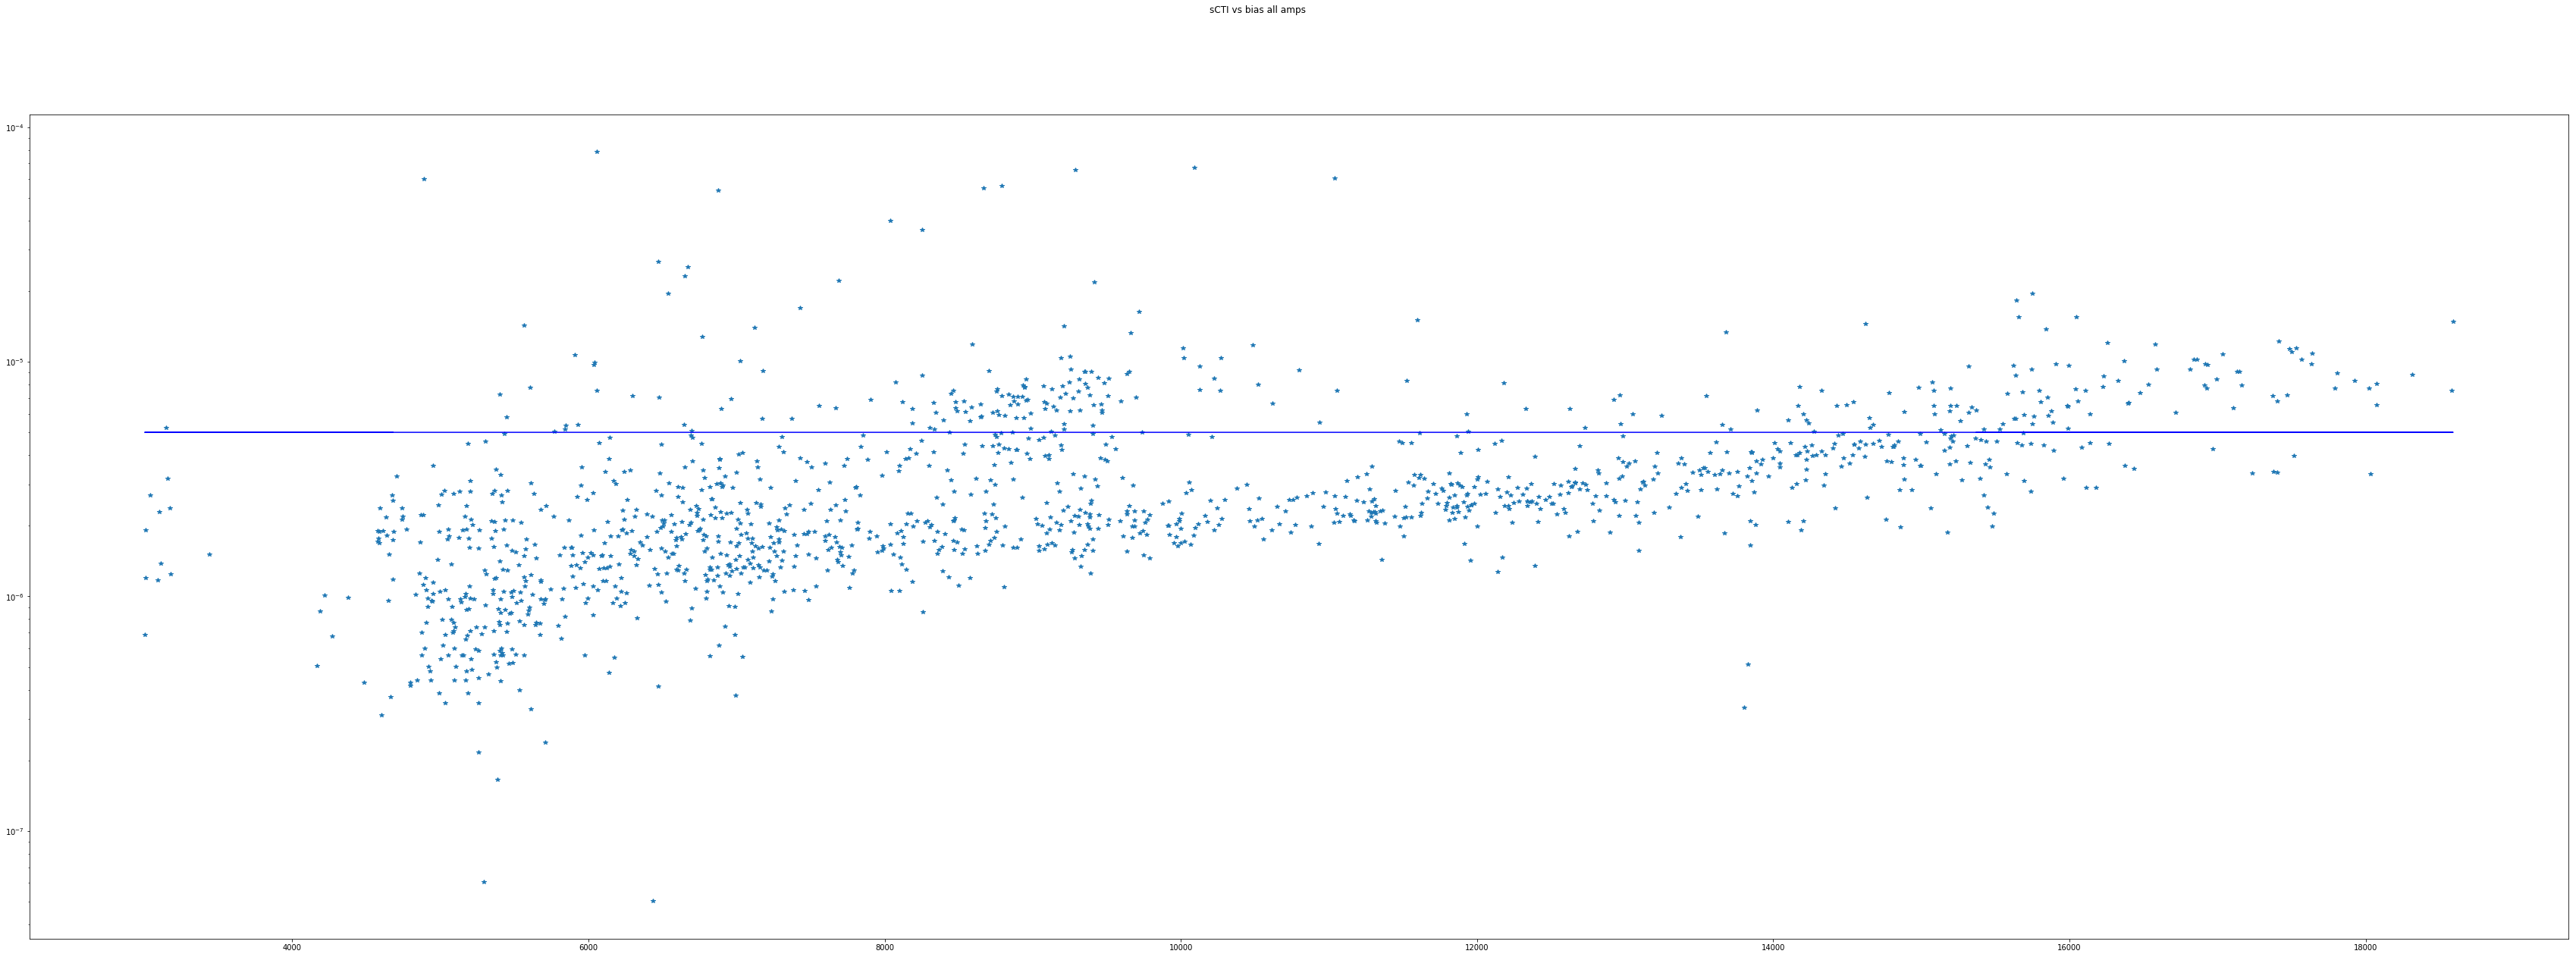

In [17]:
fig1=plt.figure(1,[figwidth,figheight])
plt.plot(ampbias,ampcitls,'*')
plt.yscale("log")
slim=0.*np.array(ampcitls)+5.e-6
plt.plot(ampbias,slim, '-b')
lab='sCTI vs bias all amps'
plt.suptitle(lab)

That interesting second population band between 8000-10000 includes the sensors that have many higher-bias segments, with two that are somewhat lower. See, e.g., 172, 208, 330, 341. These are pushed far down the list, so they should not be going on the focal plane. Would be interesting to understand them, though. 

There are also sensors in that band that have better scores, though. The following cell lists the sensors in that band, along with their scores.

In [18]:
# let's have a look at the island of sensors with bias 8000-10000 with sCTI>5e-6
for ccd in z2.index:
        defectsfrac, nbcs = defectsFraction(expDict,ccd)
        nbc=nbcs.sum()

        ctils, ctihs, ctilp, ctihp = get_CTI(expDict,ccd,0)
        ctemax=max(ctils.max(),ctihs.max())
        rn = get_readnoise(expDict,ccd)

        bias = bias_dic[ccd]
        biases = biases_dic[ccd]
        RTM = RTM_dic[ccd]
        nonlinearity = get_nonlinearity(expDict, ccd)
        
        for i in range(0,len(ctils)):
            if ((ctils[i]>5e-6) and (biases[i]>8000) and biases[i]<10000):
                print(ccd,'\n serial low (e+6):', round(1e+6*ctils[i],1), ' bias:', round(biases[i],0),' amp:',i, 'Score:',round(z2.Score[ccd],1))
                #print(round(z2.Score[ccd],1))
            



ITL-3800C-345 
 serial low (e+6): 5.8  bias: 8939.0  amp: 8 Score: 6.2
ITL-3800C-368 
 serial low (e+6): 8.1  bias: 9480.0  amp: 8 Score: 6.7
ITL-3800C-351 
 serial low (e+6): 6.1  bias: 8728.0  amp: 7 Score: 7.4
ITL-3800C-351 
 serial low (e+6): 6.7  bias: 8118.0  amp: 8 Score: 7.4
ITL-3800C-349 
 serial low (e+6): 9.1  bias: 9395.0  amp: 8 Score: 7.4
ITL-3800C-166 
 serial low (e+6): 6.4  bias: 9139.0  amp: 8 Score: 7.6
ITL-3800C-230 
 serial low (e+6): 8.7  bias: 8251.0  amp: 8 Score: 7.7
ITL-3800C-211 
 serial low (e+6): 8.9  bias: 9635.0  amp: 8 Score: 7.8
ITL-3800C-337 
 serial low (e+6): 6.5  bias: 8847.0  amp: 8 Score: 8.0
ITL-3800C-350 
 serial low (e+6): 21.8  bias: 9414.0  amp: 8 Score: 8.2
ITL-3800C-309 
 serial low (e+6): 8.5  bias: 9513.0  amp: 8 Score: 8.2
ITL-3800C-377 
 serial low (e+6): 8.0  bias: 9355.0  amp: 7 Score: 8.5
ITL-3800C-377 
 serial low (e+6): 8.2  bias: 8076.0  amp: 8 Score: 8.5
ITL-3800C-207 
 serial low (e+6): 9.1  bias: 9652.0  amp: 8 Score: 8.8
ITL-3

In [19]:
# we see that some sensors may be missing from the etraveler search. 
# to help debug, here is the list of sensors found in etraveler, sorted by 
# sensor number:
#list(df.index)

As of 17 July, there are 18 sensors that are in principle available but that do not yet have stnadard bias measurements, plus some additional sensors already on rafts that do not have standard bias measurements recorded in eTraveler. Here are the sensor numbers:


034, RTM8

072, RTM8

083, RTM8

095, RTM8

136, RTM8

142, **available**

156, RTM10

157, RTM10

160, RTM10

164, RTM8

205, RTM10

206, ** available **

226, RTM8

227, RTM8

229, ** available **

244, RTM10

251, ** available **

261, RTM10

262, ** available **

269, RTM10

308, ** available **

318, RTM10

334, ** available **

415, ** available but some problems, sent back? **

508 ** available, new awaiting bias test **


080, ** available **

092,  considered “engineering, non-compliant, worth another look?

125,  considered “engineering, non-compliant, worth another look?

127, ** available **

220, ** available **

368, glow?

376, ** available **

423, ** available **

428, ** available **

430, ** available **

476, ** available **

479, ** available ** see notes on confluence page

506  ** available**

The ones on RTMs already we can let go for now, but the ones marked ** available ** should somehow be merged into the bigger group for ranking. 11 of these haven’t had bias measurements (according to HyeYun: 080, 127, 220, 376, 423, 428, 430, 476, 479, 506, 508)), so we cannot process them.

That leaves for now only 6 (142, 206, 229, 251, 308, 334) that don’t have eT bias values from the standard method plus one mystery device (262) that should be in eT but seems not to be — perhaps it was entered within the last couple of days?

Bottom line: I think we want to address the above 18 sensors relatively soon, but it should not hold up the assignment for the next RTM.

# Compare each segment bias to the sensor bias

In [20]:
biases = pd.DataFrame(biases_dic).T
bias   = pd.DataFrame.from_dict(bias_dic, orient='index', columns=['single bias'])

In [21]:
all_biases = pd.concat([biases, bias], axis=1)

No handles with labels found to put in legend.


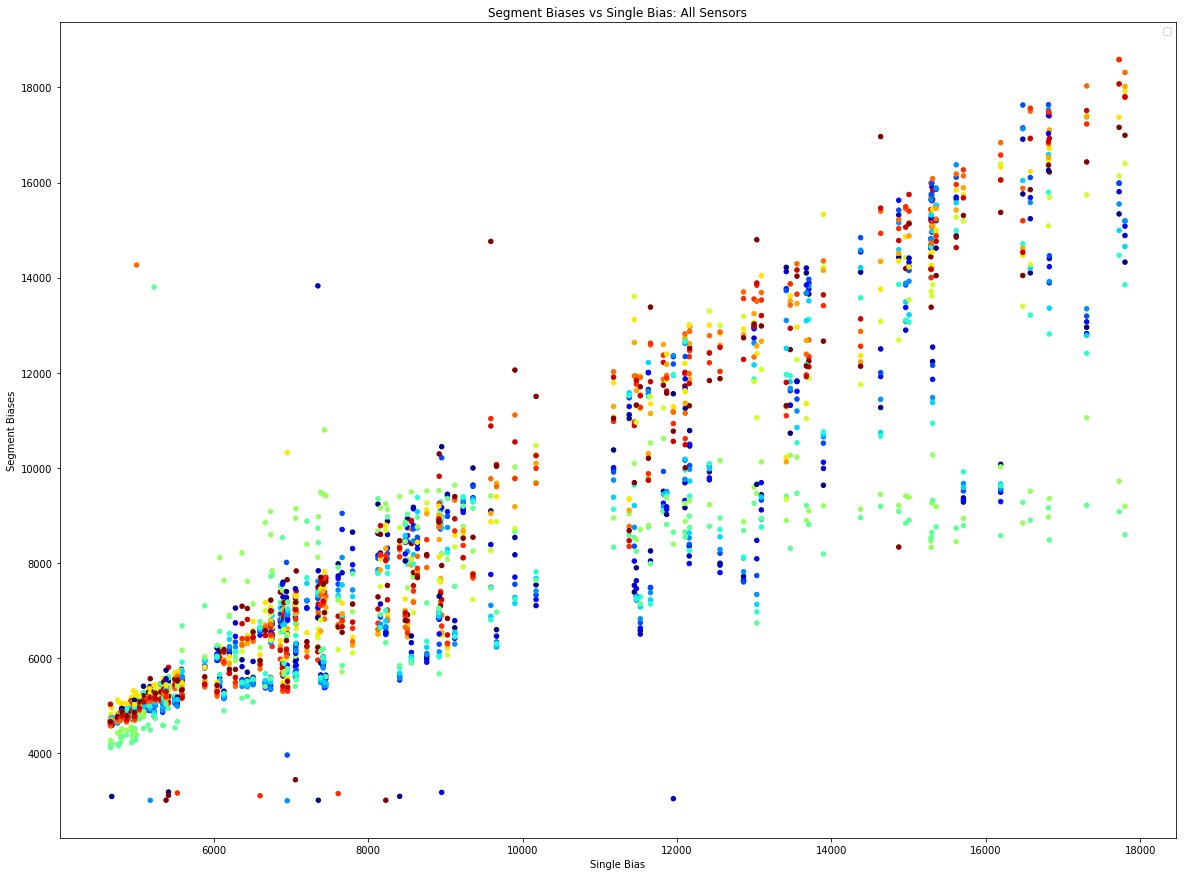

In [22]:
color_list = plt.cm.jet(np.linspace(0, 1, 16))
all_biases.plot.scatter(x=['single bias']*16, y=np.arange(16), title='Segment Biases vs Single Bias: All Sensors', c= color_list, figsize=(20,15))

plt.xlabel('Single Bias')
plt.ylabel('Segment Biases')
plt.legend()

In [23]:
ctils_list = []
for ccd in z2.index:
    ctils, ctihs, ctilp, ctihp = get_CTI(expDict,ccd,0)
    ctils_list.append(pd.DataFrame({ccd : ctils}).T)
    
ctils_all = pd.concat(ctils_list, sort=False)

Text(0,0.5,'Segment Biases')

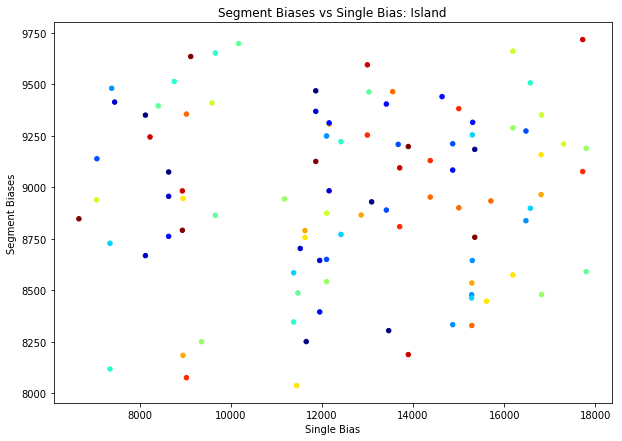

In [24]:
biases_island = biases[(biases > 8000) & (biases < 10000)][(ctils_all > 5e-6)]
all_biases_island = pd.concat([biases_island, bias], axis=1)

color_list = plt.cm.jet(np.linspace(0, 1, 16))
all_biases_island.plot.scatter(x=['single bias']*16, y=np.arange(16), title='Segment Biases vs Single Bias: Island', c=color_list, figsize=(10,7))

plt.xlabel('Single Bias')
plt.ylabel('Segment Biases')


## Serial CTI to Sensor Bias

(-2.7204239177081036e-05, 8.244575838034507e-05)

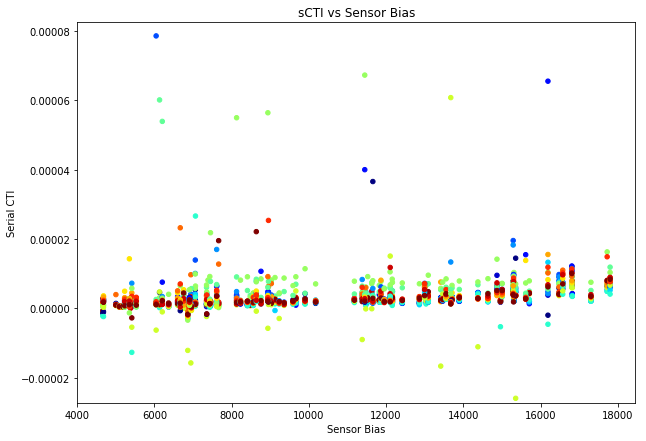

In [25]:
ctils_plot_data = pd.concat([ctils_all, bias], axis=1, sort=False)

ctils_plot_data.plot.scatter(x=['single bias']*16, y=np.arange(16), c=color_list, figsize=(10,7))
plt.xlabel('Sensor Bias')
plt.ylabel('Serial CTI')
plt.title('sCTI vs Sensor Bias')
plt.ylim(1.05*ctils_all.min().min(), 1.05*ctils_all.max().max())

There are some negative values for sCTI, but let's take their magnitude and make a log plot

In [26]:
x = np.log(np.repeat(bias.values.flatten(), 16))
#y = np.log(ctils_log_plot_data.iloc[:,0:16].values.flatten())
y = np.log(abs(ctils_all).values.flatten())
xdf = pd.DataFrame(x, columns=['x'])
ydf = pd.DataFrame(y, columns=['y'])
log_data = pd.concat([xdf,ydf], axis=1)
log_data = log_data.dropna(how='any')

In [27]:
slope, intercept, r_value, p_value, std_err = stats.linregress(log_data.x, log_data.y)

fitx = np.logspace(np.log10(4000),np.log10(18000), 1000)
fity = [np.exp(intercept)*(i**slope) for i in fitx]
print('Power: ' + str(slope))
print('Coefficient: ' + str(np.exp(intercept)))

Power: 0.316479764503488
Coefficient: 1.475929818117303e-07


(5.2741589229299285e-08, 8.244575838034507e-05)

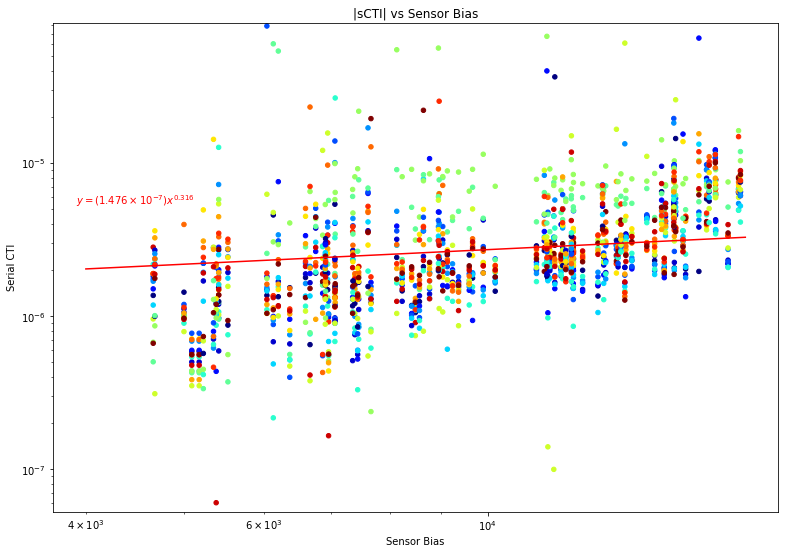

In [28]:
ctils_log_plot_data = pd.concat([ctils_all, bias], axis=1, sort=False)
ctils_log_plot_data = abs(ctils_log_plot_data)

ctils_log_plot_data.plot.scatter(x=['single bias']*16, y=np.arange(16), c=color_list, figsize=(13,9))
plt.xlabel('Sensor Bias')
plt.ylabel('Serial CTI')

plt.loglog(fitx, fity, color='r')
plt.title('|sCTI| vs Sensor Bias')
plt.figtext(0.15,0.6,r'$y = (1.476 \times 10^{-7}) x^{0.316}$', color='r')
plt.ylim(1.05*(abs(ctils_all)).min().min(), 1.05*(abs(ctils_all)).max().max())